2017 Edition

In this notebook, we will learn how to use the DataFrame API and SparkSQL to perform simple data analytics tasks.

# Goals
The main goals of this notebook are the following:
1. Understand the advantages and disadvantages of using DataFrame over RDD
2. Analyze the airline data with the DataFrame API and SparkSQL

# Steps

- First, in section 1, we will go through a short introduction about the DataFrame API with a small example to see how can we use it and how it compares to the low-level RDD abstraction.
- In section 2, we delve into the details of the use case of this notebook including: providing the context, introducing the data
- In section 3, we perform data exploration and analysis

# 1. RDD and DataFrame APIs

In our previous notebooks, we have worked with RDDs (Resilient Distributed Dataset), the basic abstraction in Spark. The main reason is due to the task at hand: we have been invovled in the design of distributed algorithms.

In this laboratory session, we study (or revisit) the DataFrame API - an immutable distributed collection of data.
DataFrames allow developers to impose a **structure** on a distributed collection of data, allowing higher-level abstraction; in addition, DataFrames provide a domain specific language (DSL) API to manipulate distributed, structured data. Ultimately, the goal is to make Spark accessible to a wider audience, beyond researchers and specialized data engineers.

Let's take a small example to see the difference between RDDs and DataFrames. The two cells below contain short code snippets that perform the same task: count the frequency of words in a document, then sort the result in descending order. The first snippet is the same you have been working on in the very [first notebook](https://github.com/EURECOM-CLOUDS-COURSE/Introduction/blob/master/introduction-lab.ipynb) of the CLOUDS course.
The second code snippet uses the DataFrame API.

<div class="alert alert-block alert-info">

<strong>Question 1.</strong> 

Run both approaches (RDD and DataFrame) detailed below, compare their runtime, and discuss. Is the DataFrame API approach faster? Can you explain why?

</div>

In [4]:
import time
time_start = time.time()
words = (
            # read the text file
            sc.textFile("/datasets/gutenberg/gutenberg_small.txt").repartition(16)
            
            # construct words from lines
            .flatMap(lambda line: line.split())
            
            # map each word to (word, 1)
            .map(lambda x: (x, 1))
    
            # reduce by key: accumulate sum the freq of the same word
            .reduceByKey(lambda freq1, freq2: freq1 + freq2)
            
            # swap (word, freq) to (freq, word)
            .map(lambda x: (x[1], x[0]))
    
            # sort result by key DESC
            .sortByKey(False)
         )
print("Runtime: {}s".format(time.time() - time_start))
print(words.take(5))

Runtime: 404.24436116218567s
[(29556020, 'the'), (18043957, 'of'), (14914748, 'and'), (12892052, 'to'), (9779124, 'a')]


In [5]:
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from pyspark.sql.functions import explode, split, desc
sqlContext = SQLContext(sc)
time_start = time.time()

# read the text file
df = sqlContext.read.text("/datasets/gutenberg/gutenberg_small.txt")

# show 3 samples
# df.show(3)

result = (
    # split into words
    df.select(explode(split(df.value, "\s+|\t+")).alias('word'))
    
    # group by each word
    .groupBy(['word'])
    
    # count the freq
    .count()
    
    # sort the result
    .orderBy(desc("count"))
)

result.show(5)
print("Runtime: {}s".format(time.time() - time_start))

+----+--------+
|word|   count|
+----+--------+
| the|29556020|
|  of|18043957|
|    |16611988|
| and|14914748|
|  to|12892052|
+----+--------+
only showing top 5 rows

Runtime: 169.91875290870667s


Yes, the DataFrameAPI approach (**169.9s**) is way faster than the one with RDDs (**404.2s**).<br>
This happens because the Dataframe is a Dataset (distributed collection of data) **organized** as in a table (into named columns); this means that, unlike the basic Spark RDD API, the interfaces provided by Spark SQL provide Spark with more information about the structure of both the data and the computation being performed, allowing **internal extra optimizations** on the finalized query.<br>
So, the biggest difference between RDDs and DataFrames, is that operations on RDDs are imperative and run through the transformations and actions **in order** whereas operations on DataFrames are **optimizable** by Spark. This means that when some operations have to be executed with RDDs, those are always performed in the specified order, while the DataFrame will actually be run through an optimizer, which will create a query plan with the operations reorganized to be more efficient without changing the result.<br><br>NB: a DataFrame is implemented as an RDD under the hood: it also results in a list of operations to be executed. The main difference is that it is an optimized list of operations. The operations you choose to perform on a DataFrame are actually run through an query optimizer (Catalyst) with a list of rules to be applied to the DataFrame, as well as put into a specialized format for CPU and memory efficiency (Tungsten).

# 2. Analysis of flight data using the DataFrame API and SparkSQL

## Use case

In this notebook, we play the role of a data scientist working in the travel industry, specifically on air transportation of passengers. We want to explore the data collected by the Department of Transportation (DoT) to understand passengers' behavior, as well as the properties of all flights, across several airline companies.

The dataset provided by the DoT has 29 features, that can be either categorical or numerical. For example, the ```src_airport``` (source airport) is categorical: there exist no comparison operator between airport names. We can not say "SGN is bigger than NCE". The ```departure_time``` feature is numerical, for which a comparison operator exists. For instance, "flight departing before 6PM" can be express by "departure_time < 1800".

In this use case, most features are numerical, except carrier, flight_number, cancelled, cancelation_code and diverted. 
The data contains a header, that is useless when analyzing the data: it serves the purpose of an "embedded schema", to help data scientist figure out what information is available. Note that there are some features with missing values in some lines of the dataset. The missing values are marked by "NA". These values can cause problems when processing the data and can lead to unexpected results. Therefore, we need to remove the header and replace all "NA" values by empty values, such as they can be interpreted as null values.

## DataFrame
As we have seen already, there are multiple ways to manipulate data:

- Using the RDD abstraction

- Using the DataFrame abstraction. 

A DataFrame is a distributed collection of data organized into named columns. It is based on the data frame concept in R language or in Pandas for Python. In some sense, it is similar to a table in a relational database: each item is a list of values (the columns). Also, the value in each row of each column can be accessed by the column's name.

To use DataFrames, the data should be clean (no invalid values). That means we cannot create DataFrame directly from the "RAW" data. Instead, we will first create an RDD from RAW data, produce a new, clean RDD, then transform it to a DataFrame and work on it. The RDD `cleaned_data` is an RDD[String]. We need to transform it to RDD[(TypeOfColumn1, TypeOfColumn2, ..., TypeOfColumn29)] then call a function to create a DataFrame from the new RDD. Please note that, package com.databricks.spark.csv can really help us to load the data efficiently without concerns about parsing, conversions, etc... However, the CSV package can have some problems when loading not well-formatted data or the data that has many kinds of missing values. The guidelines defined this notebook are a general way to help you work with any data.


DataFrames can be constructed from a wide array of sources such as: structured data files, tables in Hive, external databases, or existing RDDs.

During the labs in this course, we will mainly work with CSV data files. So, in the next sections, we only focus on constructing dataframes from structured data files directly and from existing RDD.

### Constructing a DataFrame directly from structured data file

To construct DataFrame from a structured file directly, the file type must be supported. Currently, Spark supports csv, json, avro and many more. Among these types, the csv type is one of the most popular in data analytics. A DataFrame is constructed from csv files by using the package spark-csv from Databricks.


In [3]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *

sqlContext = SQLContext(sc)

df = sqlContext.read.load('/datasets/airline/1994.csv', 
    format='com.databricks.spark.csv', 
    header='true', 
    inferSchema='true',
    nullValue='NA'
)

Using the function load parametrized with `com.databricks.spark.csv`, we ask the SqlContext to use the parser from the DataBricks package. Additionally, we can specify whether the file has a header, or ask the parser to guess the data type of columns automatically. The parsed data types is viewed using the function printSchema.

In [2]:
# print(df.dtypes)
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |

As you can see, the automatically inferred data types are **not** as expected. For example, we expect that CRSDepTime to be of interger type. The type and the name of each column can be modified using function ```withColumn``` and ```withColumnRename``` respectively. Additionally, we can also compute and print basic descriptive statistics of numerical columns via the function ```describe``` (similar to Pandas).

In [3]:
df = (df
          # change type of column CRSDepTime by casting its values to interger type
          .withColumn('CRSDepTime', df.CRSDepTime.cast('int'))

          # rename the column
          .withColumnRenamed('CRSDepTime', 'scheduled_departure_time')
    )

# print schema of the current data
df.printSchema()

# run jobs to calculate basic statistic information and show it
df.describe().show()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nulla

### Constructing a DataFrame from an existing RDD

Another way to construct a DataFrame is using data from an existing RDD. The main advantage of this approach is that it does not need a third party library. However, with this method, we have to remove the header ourself and provide a clear schema.



In [1]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import explode, split, desc, col, udf, round
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
import seaborn as sns

In [2]:
sqlContext = SQLContext(sc)

data = sc.textFile('/datasets/airline/1994.csv')

# extract the header
header = data.first()

# replace invalid data with NULL and remove header
cleaned_data = (
        data
    
        # filter out the header
        .filter(lambda line: line != header)
    
         # replace the 'missing data' by empty value
        .map(lambda line: ','.join(list(map(lambda x: x if x != 'NA' else '',line.split(',')))))
    )

airline_data_schema = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("year",                     IntegerType(), True), \
    StructField("month",                    IntegerType(), True), \
    StructField("day_of_month",             IntegerType(), True), \
    StructField("day_of_week",              IntegerType(), True), \
    StructField("departure_time",           IntegerType(), True), \
    StructField("scheduled_departure_time", IntegerType(), True), \
    StructField("arrival_time",             IntegerType(), True), \
    StructField("scheduled_arrival_time",   IntegerType(), True), \
    StructField("carrier",                  StringType(),  True), \
    StructField("flight_number",            StringType(),  True), \
    StructField("tail_number",              StringType(), True), \
    StructField("actual_elapsed_time",      IntegerType(), True), \
    StructField("scheduled_elapsed_time",   IntegerType(), True), \
    StructField("air_time",                 IntegerType(), True), \
    StructField("arrival_delay",            IntegerType(), True), \
    StructField("departure_delay",          IntegerType(), True), \
    StructField("src_airport",              StringType(),  True), \
    StructField("dest_airport",             StringType(),  True), \
    StructField("distance",                 IntegerType(), True), \
    StructField("taxi_in_time",             IntegerType(), True), \
    StructField("taxi_out_time",            IntegerType(), True), \
    StructField("cancelled",                StringType(),  True), \
    StructField("cancellation_code",        StringType(),  True), \
    StructField("diverted",                 StringType(),  True), \
    StructField("carrier_delay",            IntegerType(), True), \
    StructField("weather_delay",            IntegerType(), True), \
    StructField("nas_delay",                IntegerType(), True), \
    StructField("security_delay",           IntegerType(), True), \
    StructField("late_aircraft_delay",      IntegerType(), True)\
])

In [3]:
# convert each line into a tuple of features (columns) with the corresponding data type
cleaned_data_to_columns = (
    cleaned_data.map(lambda l: l.split(","))
    .map(lambda cols: 
         (
            int(cols[0])  if cols[0] else None,
            int(cols[1])  if cols[1] else None,
            int(cols[2])  if cols[2] else None,
            int(cols[3])  if cols[3] else None,
            int(cols[4])  if cols[4] else None,
            int(cols[5])  if cols[5] else None,
            int(cols[6])  if cols[6] else None,
            int(cols[7])  if cols[7] else None,
            cols[8]       if cols[8] else None,
            cols[9]       if cols[9] else None,
            cols[10]      if cols[10] else None,
            int(cols[11]) if cols[11] else None,
            int(cols[12]) if cols[12] else None,
            int(cols[13]) if cols[13] else None,
            int(cols[14]) if cols[14] else None,
            int(cols[15]) if cols[15] else None,
            cols[16]      if cols[16] else None,
            cols[17]      if cols[17] else None,
            int(cols[18]) if cols[18] else None,
            int(cols[19]) if cols[19] else None,
            int(cols[20]) if cols[20] else None,
            cols[21]      if cols[21] else None,
            cols[22]      if cols[22] else None,
            cols[23]      if cols[23] else None,
            int(cols[24]) if cols[24] else None,
            int(cols[25]) if cols[25] else None,
            int(cols[26]) if cols[26] else None,
            int(cols[27]) if cols[27] else None,
            int(cols[28]) if cols[28] else None
         ))             
)
    
# create dataframe
df = sqlContext.createDataFrame(cleaned_data_to_columns, airline_data_schema)\
    .select(['year', 'month', 'day_of_month', 'day_of_week',
            'scheduled_departure_time','scheduled_arrival_time',
            'arrival_delay', 'distance', 
            'src_airport', 'dest_airport', 'carrier'])\
    .cache()

### Examples

Using the contructed DataFrame, we can answer some simple questions:

<ul>
<li>How many night flights do we have in our data?</li>
<li>How many night flights per unique carrier?</li>
</ul>

<strong>NOTE:</strong> We define "night" to start at 6pm.

In [10]:
df[df.scheduled_departure_time > 1800].count()

1078203

In [12]:
df[df.scheduled_departure_time > 1800].groupBy(df.carrier).count().orderBy('count', ascending=0).show()

+-------+------+
|carrier| count|
+-------+------+
|     DL|208224|
|     US|170397|
|     AA|142832|
|     WN|124024|
|     UA|113640|
|     NW|100453|
|     CO| 94501|
|     TW| 54771|
|     HP| 44351|
|     AS| 25010|
+-------+------+



# 3. Data exploration
Next, we will go over a series of simple queries on our data, to perform exploration and compute statistics using the DataFrame API and SparkSQL. These queries directly map to the questions you need to answer. 

**NOTE:** finding the right question to ask is difficult! Don't be afraid to complement the questions below, with your own questions that, in your opinion, are valuable ways to inspect data. This can give you extra points!

- Basic queries:
  - How many unique origin airports?
  - How many unique destination airports?
  - How many carriers?
  - How many flights that have a scheduled departure time later than 18h00?


- Statistics on flight volume: this kind of statistics are helpful to reason about delays. Indeed, it is plausible to assume that "*the more flights in an airport, the higher the probability of delay*".
  - How many flights in each month of the year?
  - Is there any relationship between the number of flights and the days of week?
  - How many flights in different days of months and in different hours of days?
  - Which are the top 20 busiest airports (this depends on inbound and outbound traffic)?
  - Which are the top 20 busiest carriers?


- Statistics on the fraction of delayed flights
  - What is the percentage of delayed flights (over total flights) for different hours of the day?
  - Which hours of the day are characterized by the longest flight delay?
  - What are the fluctuation of the percentage of delayed flights over different time granularities?
  - What is the percentage of delayed flights which depart from one of the top 20 busiest airports?
  - What is the percentage of delayed flights which belong to one of the top 20 busiest carriers?

## Question 2: Basic queries

### Question 2.1
<div class="alert alert-info">

How many origin airports? How many destination airports? Discuss the results, indicating any discrepancies or strange facts about the data.

</div>

In [13]:
unq_origin = df.select('src_airport').distinct().count()
print("Unique origin airports:", unq_origin)

dst_dest = df.select('dest_airport').distinct().count()
print("Unique destination airports:", dst_dest)

Unique origin airports: 224
Unique destination airports: 225


The number of **unique** source (224) and destination (225) airports differ by 1. In teory, this would mean that one of the airports is never used as a source airport but only as a destination one, which is strange for an airport.<br>
So this could indicate that there are errors or missing of data in the input file.

In [14]:
print('The airport which are present as source only are:')
# to discover which is the airports that is present only as destination, we subtract the destination column to the origin one.
df.select('src_airport').subtract(df.select('dest_airport')).show()

print('The airports which are present as destination only are:')
# to discover which is the airports that is present only as destination, we subtract the destination column to the origin one.
df.select('dest_airport').subtract(df.select('src_airport')).show()

The airport which are present as source only are:
+-----------+
|src_airport|
+-----------+
|        SPN|
+-----------+

The airports which are present as destination only are:
+------------+
|dest_airport|
+------------+
|         BFI|
|         GUM|
+------------+



To better analyze the situation we have calculated WHICH are the airports present as only source or destination; by doing this, we have seen that actually, in the considered dataset, there is one airport that is present as source only, and two airports present as destination only (while it was expected only one airport in the destination!).<br>
After having answered to the question 5.1, we have seen that in the whole dataset there is no airport present as source only! So this mean that the one which appear here - SPN - is present as destination in some other dataset. The same speech can be done for the destinations.<br>
So this confirm what we have assumed before: there are missing data in the 1994 dataset.

### Question 2.2

<div class="alert alert-info">
How many unique carriers are present in the data?
</div>

In [15]:
carrier = df.select('carrier').distinct().count()
print("Unique carriers:", carrier)

Unique carriers: 10


### Question 2.3

<div class="alert alert-info">
<ul>
<li>How many night flights (that is, flights departing later than 6pm or earlier than 6am)?</li>
<li>What is the percentage of night flights over the total volume of flights</li>
</ul>

<br>
<br>
<strong>NOTE:</strong> Here we're using a more refined definition of what is a night flight, than in our earlier examples.

</div>

In [16]:
ngt_flt = df[(df.scheduled_departure_time > 1800) | (df.scheduled_departure_time < 600)].count()
print("Night flights:", ngt_flt)

tot_flt = df.count()
print("Night flight percentage: %f%%" % (100*ngt_flt/tot_flt))

Night flights: 1121918
Night flight percentage: 21.658448%


## Question 3: Flight volume statistics

### Question 3.1: 

<div class="alert alert-info">
How many flights in each month of the year? Plot the changes over months by a line chart and comment the figure.

<br>
From the result, we can learn the dynamics of flight volume over months. For example, if we only consider flights in 1994 (to start, it's always better to focus on smaller amount of data), we can discuss about which months are most likely to have flights experiencing delays.
</div>


+-----+------+
|month| count|
+-----+------+
|    1|423861|
|    2|386954|
|    3|435516|
|    4|420995|
|    5|436432|
|    6|426490|
|    7|443736|
|    8|451086|
|    9|430861|
|   10|449369|
|   11|428227|
|   12|446521|
+-----+------+



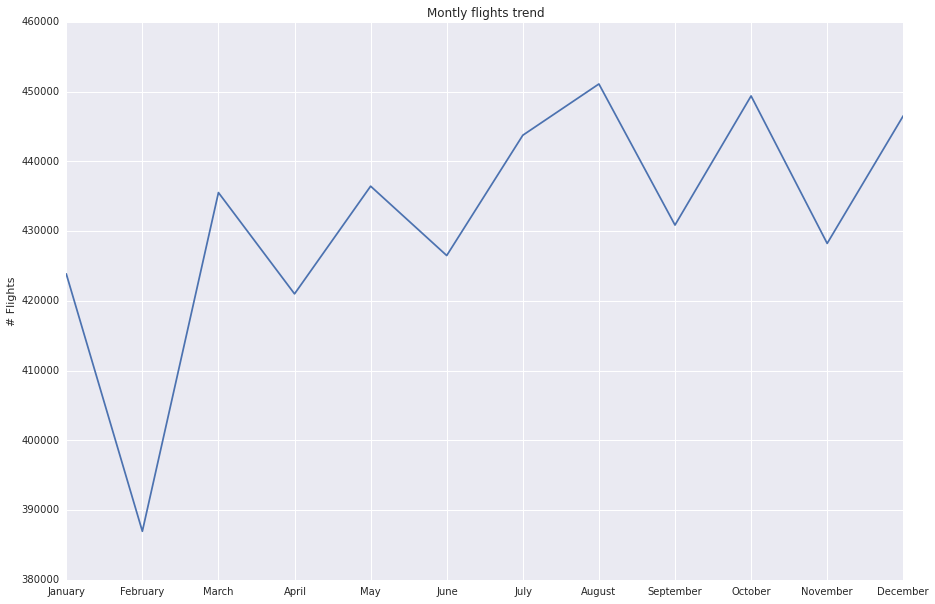

In [17]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# QUERY
# groupBy month and count the rows for each group. Then order by month to simplify the plotting.
# we have never grouped by year because we are considering only the 1994 dataset.
month_count = df.groupBy(df.month).count().orderBy(df.month)


# PRINT & COLLECT
month_count.show()
month_count = month_count.collect()

    
# PLOT
plt.figure(figsize=(15,10))
plt.plot([x for x in range(len(months))], [x[1] for x in month_count])
plt.xticks([x for x in range(len(months))], months)
plt.xlim(0, len(months)-1)
plt.title('Montly flights trend')
plt.ylabel('# Flights')
plt.show()

By looking at the produced line plot we can analize the flights trend with respect to each month of the year (on the x are reported the months, on the y the total number of flights).<br>
As expected, the number of flights increases during the summer months (in particular it reaches its maximum value in August) and in general during the holidays (in fact the second and third maximum values are in October and December).<br>
Instead, the month with less flights is February.<br>
Moreover, it's possibile to see that, in average, there are more flights in the second half of the year respect to the first half.<br>

### Question 3.2: 

<div class="alert alert-info">
Is there any relationship between the number of flights and the days of the week?  

Plot a bar chart and interpret the figure.

<br>
<br>
<strong>NOTE:</strong> You should study both global aggregates (irrespectively of the month of the year), and monthly aggregates (day statistics, for each different month of the year).

<br>
<br>
By answering this question, we could learn about the importance of the weekend/weekday feature for our predictive task.
</div>

+-----------+------+
|day_of_week| count|
+-----------+------+
|          1|754636|
|          2|756532|
|          3|756864|
|          4|751537|
|          5|751531|
|          6|695245|
|          7|713703|
+-----------+------+



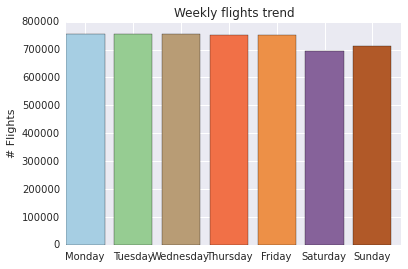

+-----+-----------+-----+
|month|day_of_week|count|
+-----+-----------+-----+
|    1|          1|70761|
|    1|          2|56327|
|    1|          3|55944|
|    1|          4|55870|
|    1|          5|56041|
|    1|          6|62488|
|    1|          7|66430|
|    2|          1|56645|
|    2|          2|56549|
|    2|          3|56460|
|    2|          4|56421|
|    2|          5|56823|
|    2|          6|50611|
|    2|          7|53445|
|    3|          1|57356|
|    3|          2|71424|
|    3|          3|71900|
|    3|          4|71942|
|    3|          5|57400|
|    3|          6|51347|
+-----+-----------+-----+
only showing top 20 rows



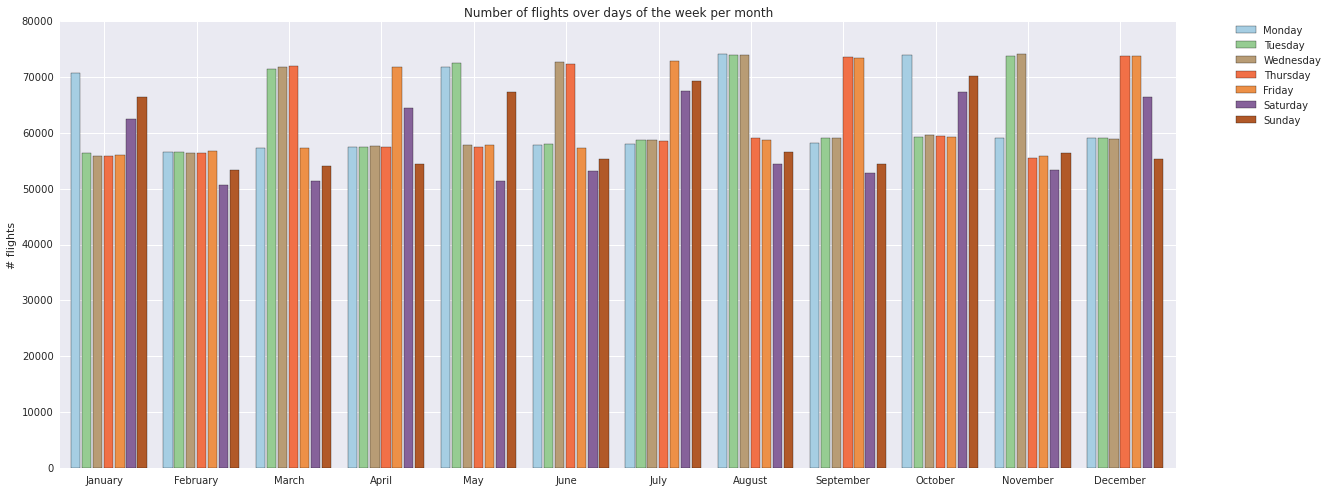

In [18]:
from matplotlib import cm

days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
colors = cm.Paired(np.linspace(0, 1, 7))


### global aggregates ###

# QUERY
# groupby day of week and count the rows for each group. Then orderb by day of week to simplify plotting
days_count = df.groupBy(df.day_of_week).count().orderBy('day_of_week')


# PRINT & COLLECT
days_count.show()
days_count = days_count.collect()


# PLOT
plt.bar([x for x in range(len(days_of_week))], [x[1] for x in days_count], color=colors)
plt.xticks([x+0.4 for x in range(len(days_of_week))], days_of_week)
plt.title('Weekly flights trend')
plt.ylabel('# Flights')
plt.show()


### monthly aggregates ###

# QUERY
# groupby month and day of week, and count the rows for each group. In this way we may compute the count for each week for each month. 
# Then orderb by day of week to simplify plotting
days_count = df.groupBy(df.month, df.day_of_week).count().orderBy(df.month, df.day_of_week)


# PRINT & COLLECT
days_count.show()
days_count = days_count.collect()


# PLOT
pos = list(range(len(months)))
width = 0.12

fig, ax = plt.subplots(figsize=(20,8))

for d in range(len(days_of_week)):
    data_values = []
    for m in range(len(months)):
        data_values.append(days_count[m*len(days_of_week)+d][2])
    plt.bar([p + width*d for p in pos], data_values, width-0.02, color=colors[d])
    
ax.set_ylabel('# flights')
ax.set_title('Number of flights over days of the week per month')
ax.set_xticks([p + 3 * width for p in pos])
ax.set_xticklabels(months)
plt.xlim(min(pos)-width, max(pos)+width*(len(days_of_week)+1))

plt.legend(days_of_week, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

NB: first of all, for the monthly aggregates we decided to use one single plot to avoid losing the information which results by comparing the same days of the week in different months (the same days of week are represented with the same color). In this case it's still possible to represent the whole plot in this format.<br><br>

In the first plot we consider the cumulated number of flights over the entire year; on the x are reported the days of the week, on the y the total number of flights. In the second plot, instead, are represented the days of the week for each month.
Looking at the produced plots we can see how the number of flights really depends on the day of the week; however, this correlation varies also depending on the month.<br>
Looking at the global aggregation (first plot) it seems that in general the days with less flights are Saturday and Sunday; this was expected because, if we consider people who fly for travel, they may try to not fly during the weekend. However, this is not true for every month: from the second plot, it's easy to see how, for some months of the year (as July for example), the weekend days are the busiest ones.<br>
In August, for example (which was also the month with the higher number of flights), the first half of the week registers a number of flights way higher respect to the second half. This could happen because in that month people are used to take longer holidays, so they depart at the beginning of the week. While the reverse trend is registered in others months, in particular during the winter (October, December and January), where people are most likely to travel during the weekend.<br>

### Question 3.3

<div class="alert alert-info">
How many flights in different days of months and in different hours of days?  
<br>
<br>

<strong>NOTE:</strong> Similarly to the previous note, you need to compute both global statistcs and monthly statistics.

<br>
<br>
Plot  bar charts, and interpret your figures.
</div>

+------------+------+
|day_of_month| count|
+------------+------+
|           1|169674|
|           2|169829|
|           3|168678|
|           4|169399|
|           5|168423|
|           6|170650|
|           7|172210|
|           8|170674|
|           9|170077|
|          10|170252|
|          11|172362|
|          12|169542|
|          13|171230|
|          14|172081|
|          15|170737|
|          16|169985|
|          17|170132|
|          18|171868|
|          19|169483|
|          20|171142|
+------------+------+
only showing top 20 rows



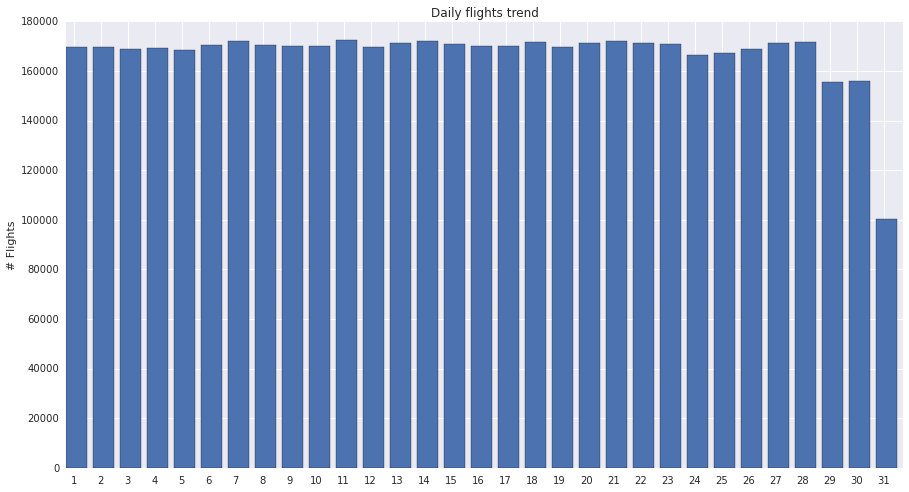

+-----+------------+-----+
|month|day_of_month|count|
+-----+------------+-----+
|    1|           1|12158|
|    1|           2|13579|
|    1|           3|14204|
|    1|           4|14183|
|    1|           5|14122|
|    1|           6|14049|
|    1|           7|14072|
|    1|           8|12605|
|    1|           9|13228|
|    1|          10|14122|
|    1|          11|14121|
|    1|          12|14166|
|    1|          13|14062|
|    1|          14|14026|
|    1|          15|12540|
|    1|          16|13013|
|    1|          17|14013|
|    1|          18|13916|
|    1|          19|13776|
|    1|          20|13868|
+-----+------------+-----+
only showing top 20 rows



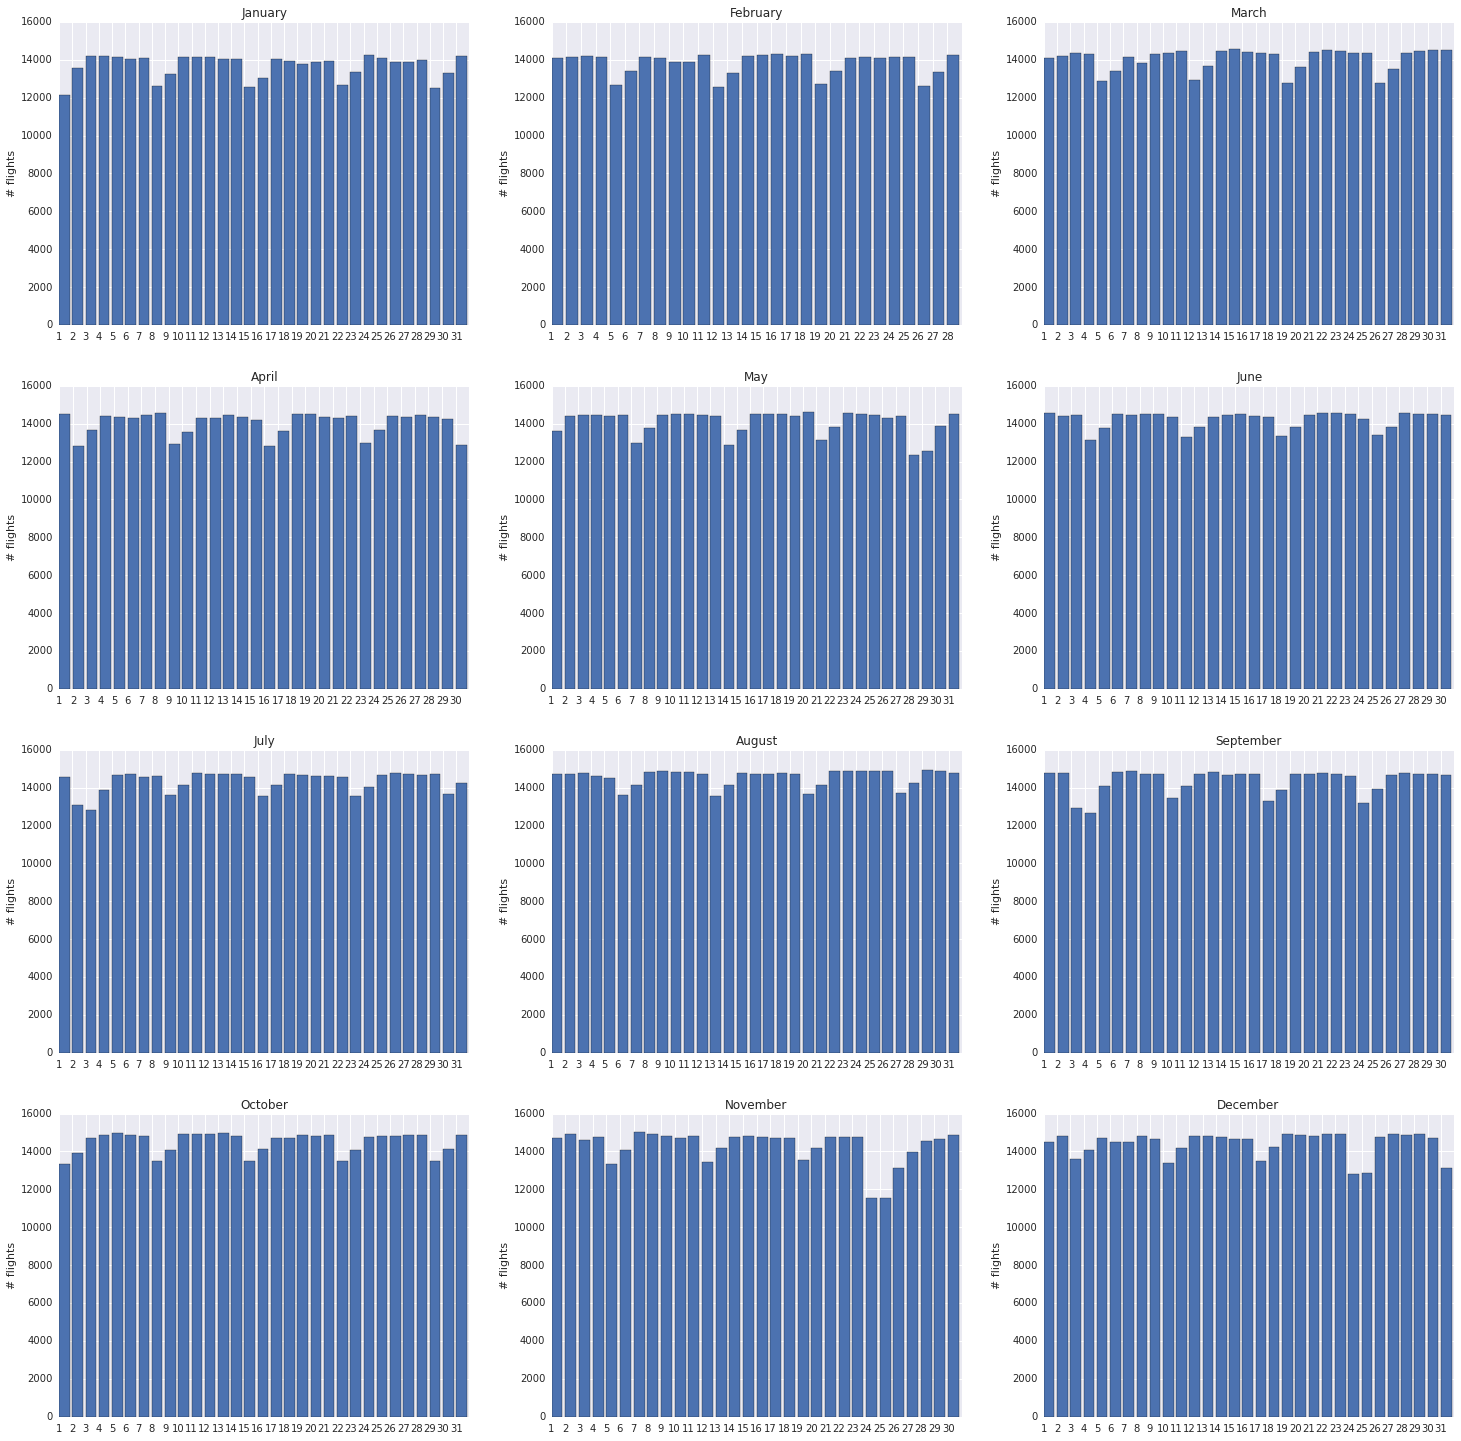

In [19]:
### global aggregates ###

# QUERY
# groupby day of month, and count the rows for each group. In this way we are grouping each day also if in different months.
days_month_count = df.groupBy(df.day_of_month).count().orderBy(df.day_of_month)


# PRINT & COLLECT
days_month_count.show()
days_month_count = days_month_count.collect()


# PLOT
plt.figure(figsize=(15,8))
plt.bar([x for x in range(len(days_month_count))], [x[1] for x in days_month_count])
plt.xticks([x+0.3 for x in range(len(days_month_count))], [x+1 for x in range(len(days_month_count))])
plt.xlim(0, 31)
plt.title('Daily flights trend')
plt.ylabel('# Flights')
plt.show()





### monthly aggregates ###

# QUERY
# groupby month and day of month, and count the rows for each group. In this way we may compute the count for each day for each month. 
days_month_count = df.groupBy(df.month, df.day_of_month).count().orderBy(df.month, df.day_of_month)


# PRINT
days_month_count.show()


# PLOT
nr = 4
nc = 3
plt.figure(figsize=(25, 25))
for i in range(12):
    monthly_counts = days_month_count[df.month == i+1].select('count').collect()
    plt.subplot(nr, nc, i+1)
    plt.bar([x for x in range(len(monthly_counts))], [x[0] for x in monthly_counts])
    plt.ylabel('# flights')
    plt.title(months[i])
    plt.xticks([p for p in range(len(monthly_counts))], [p+1 for p in range(len(monthly_counts))])
    plt.xlim(0, len(monthly_counts))
plt.show()

In this case, for the montly statistics, it was impossible to represent the whole picture with all the days for each month in the same image; so we choose to represent per month plots.<br><br>
For each plot, on the x axis are reported the days of the month (0-31), on the y the total number of flights (cumulated globally in the first chart, and monthly for the others).<br>
Obviously, it's clear that in the global aggregate plot, the day 31 registers the half of flights respect to the others because not every month has that day.<br>
In general we can say that during the US holidays, the number of flights is less then the monthly average, while an increment is registered in the days right before or after: this because, eventually, people may try to reach their families, or in general to travel, during those day. In fact, the most interesting thing to see is the flights behaviour during the holiday days: for example during Christmas (24-25 December), or at the end of the year (31 December), or during the Thanksgiving day (4th Thursday of November: 24), the number of flights is less respect to the montly average.<br>
Moreover, that plot confirms what we have seen from the previouse one: the "monthly trend" oscillate depending on the day of the week!<br>

+-----------+------+
|hour_of_day| count|
+-----------+------+
|          0| 13642|
|          1| 12825|
|          2|  2842|
|          3|   564|
|          4|   486|
|          5| 13357|
|          6|257486|
|          7|398796|
|          8|397060|
|          9|341597|
|         10|300375|
|         11|313577|
|         12|356830|
|         13|360762|
|         14|294214|
|         15|313131|
|         16|317809|
|         17|368695|
|         18|338147|
|         19|287033|
+-----------+------+
only showing top 20 rows



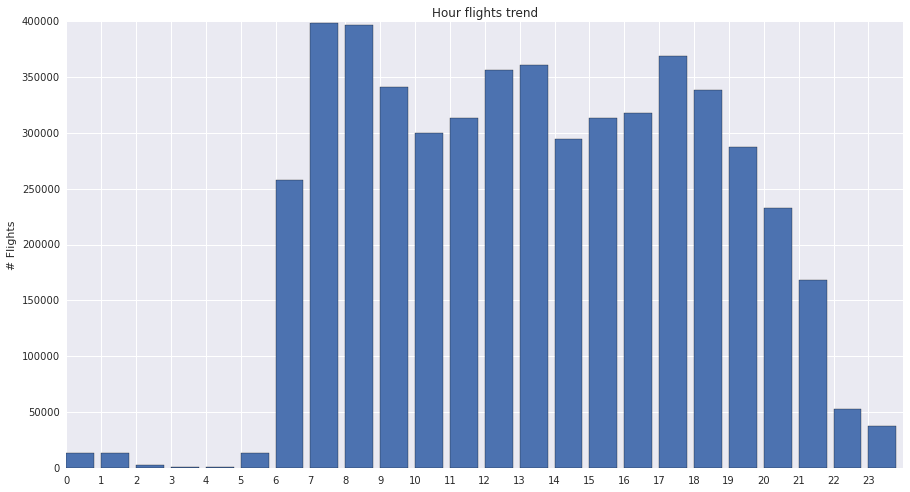

+-----+-----------+-----+
|month|hour_of_day|count|
+-----+-----------+-----+
|    1|          0| 1154|
|    1|          1|  901|
|    1|          2|  238|
|    1|          3|   62|
|    1|          4|   33|
|    1|          5| 1017|
|    1|          6|21360|
|    1|          7|31184|
|    1|          8|32814|
|    1|          9|28242|
|    1|         10|24073|
|    1|         11|26409|
|    1|         12|28302|
|    1|         13|30128|
|    1|         14|24179|
|    1|         15|25659|
|    1|         16|26598|
|    1|         17|30522|
|    1|         18|27939|
|    1|         19|23358|
+-----+-----------+-----+
only showing top 20 rows



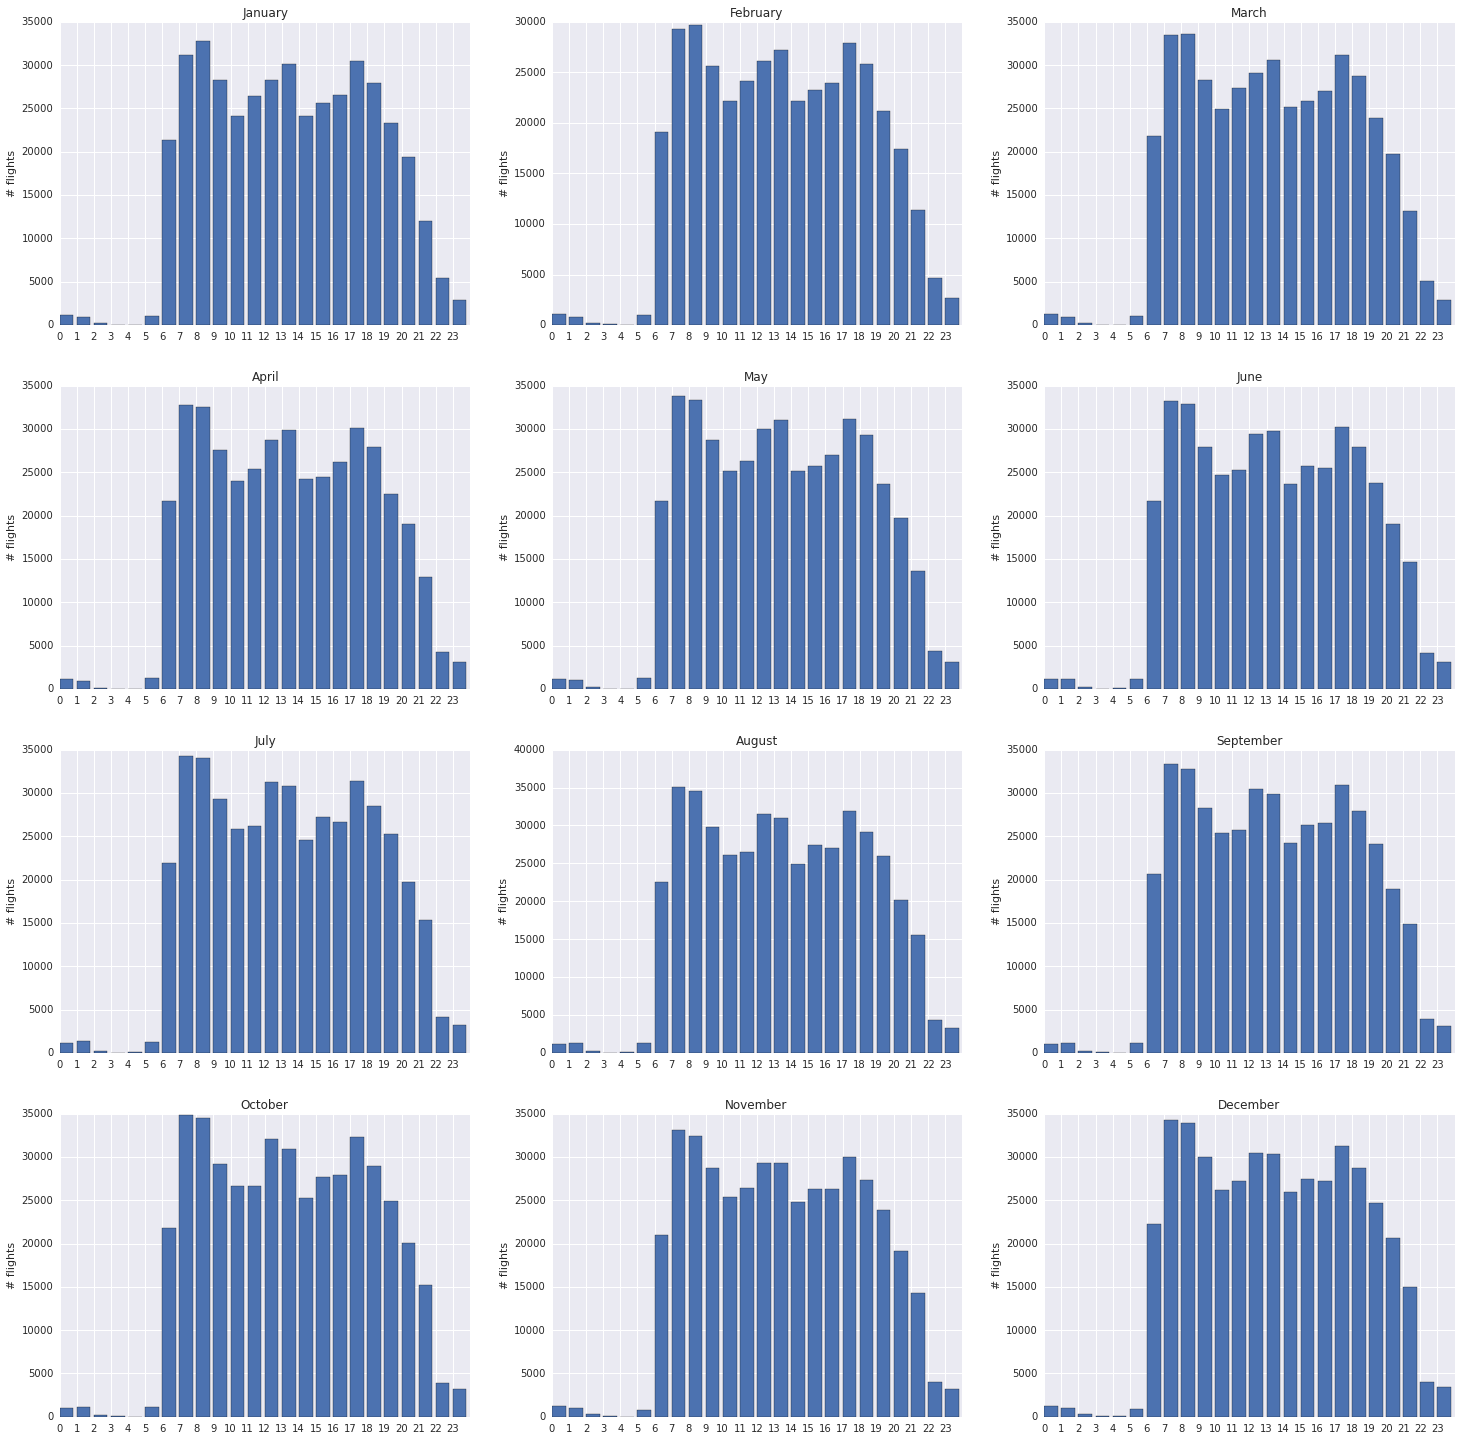

In [68]:
### FLIGHTS IN DIFFERENT HOURS OF DAY ###

# in this case, in order to group by hour, since in the database the hours are reported also considering the minutes,
# we add a column "hour_of_day", which contains the hour as an integer (from 0 to 23). so we can group by this column
# (both for global and monthly aggregates) to make the hourly groups

# NB: in the dataset there 00:00 is written as 24:00 (2400), so we do 'mod 24'
df_hour_day = df.withColumn('hour_of_day', ((df.scheduled_departure_time/100).cast('int'))%24)


### global aggregates ###

# QUERY
# groupy by hour without considering the months, then count the rows in the group to obtain the number of flights
hour_count = df_hour_day.groupBy('hour_of_day').count().orderBy('hour_of_day')


# PRINT & COLLECT
hour_count.show()
hour_count = hour_count.collect()


# PLOT
plt.figure(figsize=(15,8))
plt.bar([x for x in range(len(hour_count))], [x[1] for x in hour_count])
plt.xticks([x for x in range(len(hour_count))], [x for x in range(len(hour_count))])
plt.xlim(0, 24)
plt.title('Hour flights trend')
plt.ylabel('# Flights')
plt.show()





### monthly aggregates ###

# QUERY
# groupb by month and the added column (hour) to compute the number of flights (count) for each hour of day separated for month
monthly_hour_count = df_hour_day.groupBy(df.month, 'hour_of_day').count().orderBy(df.month,'hour_of_day')


# PRINT
monthly_hour_count.show()


# PLOT
nr = 4
nc = 3
plt.figure(figsize=(25, 25))
for i in range(12):
    monthly_counts = monthly_hour_count[df.month == i+1].select('count').collect()
    plt.subplot(nr, nc, i+1)
    plt.bar([x for x in range(len(monthly_counts))], [x[0] for x in monthly_counts])
    plt.ylabel('# flights')
    plt.title(months[i])
    plt.xticks([p for p in range(len(monthly_counts))], [p for p in range(len(monthly_counts))])
    plt.xlim(0, len(monthly_counts))

plt.show()

NB: in the considered dataset the midnight (00:00) is reported as 24:00, so we do 'mod 24'.<br>
Also in this case we decided to produce one plot for each month because it would have been a mess doing it in one single image.<br><br>
For each plot, on the x axis are reported the hours of the day (0-24), on the y the total number of flights (cumulated globally in the first chart, and monthly for the others).<br>
The scheduled departure time has been considered to compute the count.<br>
From those plots, as expected, it's really evident how in general the number of flight during the "night" (from 22 to 5am) is way less than the other hours of the day, and this trend is true for each month of the year.<br>
This could bring to the conclusion that during the night the probability of experiencing a delay is lower than during the day!<br>
A relevant fact is that there are some peaks at some particular hours of the day, and this is true for each month: for example at 7am, 12am and 18 am, are registered the highest numbers. Those could be the most crowded hours of the day, so the hours most subjected to delay!

### Question 3.4

<div class="alert alert-info">
Which are the **top 20** busiest airports? Compute this in terms of the inbound, outbound and total number of flights.
</div>

In [21]:
# Departing flights
print("Outbound traffic:")
# group by origin airport and count the row numbers. then ordering in reverse order (from highest)
src_flights = df.groupBy(df.src_airport).count().orderBy('count', ascending=0)
src_flights.show()

# Landing flights
print("Inbound traffic:")
# group by destination airport and count the row numbers. then ordering in reverse order (from highest)
dest_flights = df.groupBy(df.dest_airport).count().orderBy('count', ascending=0)
dest_flights.show()

# Departing + landing flights
print("Inbound + outbound traffic:")
# in this case we generate a new dataframe which contains a new column ('airport'), which is the result
# of the union of the sources and the destinations airports information for each flight
df_airport = df.withColumn('airport', df.src_airport).union(df.withColumn('airport', df.dest_airport))
top_busiest_airport = df_airport.groupBy('airport').count().orderBy('count', ascending=0)
top_busiest_airport.show()

Outbound traffic:
+-----------+------+
|src_airport| count|
+-----------+------+
|        ORD|277741|
|        DFW|256274|
|        ATL|221486|
|        LAX|153494|
|        STL|151609|
|        DEN|141427|
|        PHX|139581|
|        DTW|136837|
|        PIT|130977|
|        CLT|129391|
|        MSP|123222|
|        SFO|118233|
|        EWR|116768|
|        IAH|104182|
|        LGA|101864|
|        BOS|100365|
|        LAS| 94972|
|        PHL| 93585|
|        DCA| 88445|
|        MCO| 77120|
+-----------+------+
only showing top 20 rows

Inbound traffic:
+------------+------+
|dest_airport| count|
+------------+------+
|         ORD|283720|
|         DFW|260249|
|         ATL|221588|
|         LAX|152959|
|         STL|152800|
|         DEN|144099|
|         PHX|140979|
|         DTW|139435|
|         PIT|131962|
|         CLT|130321|
|         MSP|124758|
|         SFO|117245|
|         EWR|117223|
|         IAH|104409|
|         LGA|101498|
|         BOS| 99331|
|         LAS| 94

When computing the top 20 busiest airports we may consider only departing flights, only landing flights or both (the sum), so in this case we have produced three different schemas.<br>
Anyhow, from now on we will consider as top busiest airports the "aggregated" (considering source + destination flights) version.

### Question 3.5
<div class="alert alert-info">
Which are the **top 20** busiest carriers? Compute this in terms of number of flights.
</div>


In [22]:
top_busiest_carriers = df.groupBy(df.carrier).count().orderBy('count', ascending=0)
top_busiest_carriers.show()

+-------+------+
|carrier| count|
+-------+------+
|     DL|874526|
|     US|857906|
|     AA|722277|
|     UA|638750|
|     WN|565426|
|     CO|484834|
|     NW|482798|
|     TW|258205|
|     HP|177851|
|     AS|117475|
+-------+------+



NB: in the considered dataset there are only 10 different carriers

## Question 4 
In this series of questions we focus on the computation of statistics about the percentage of delayed flights.

### Question 4.1
<div class="alert alert-info">
What is the percentage of delayed flights for different hours of the day?  

Plot a bar chart and interpret the figure.  


<div class="label label-success">IMPORTANT!</div> A flight is considered as delayed if it's actual arrival time is more than 15 minutes later than the scheduled arrival time.

</div>

+-----------+------------------+
|hour_of_day|       delay_ratio|
+-----------+------------------+
|          0| 17.09426770268289|
|          1|14.838206627680313|
|          2| 5.348346235045742|
|          3|1.5957446808510638|
|          4|   5.1440329218107|
|          5| 6.094182825484765|
|          6| 8.068399835330853|
|          7|10.564549293373053|
|          8|13.353901173626152|
|          9| 14.67870033987418|
|         10|13.552392842280483|
|         11|14.784247569177586|
|         12|15.775859653056077|
|         13|16.822448040536422|
|         14|17.263964325287034|
|         15| 19.96640383737158|
|         16|20.660837169494886|
|         17|22.946880212641886|
|         18|22.302134870337458|
|         19|23.267011110220775|
+-----------+------------------+
only showing top 20 rows



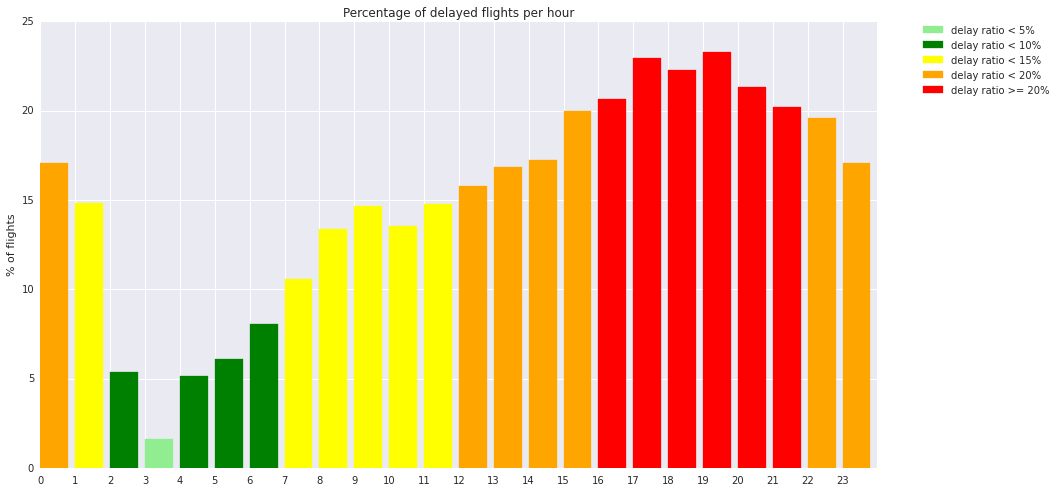

+-----+-----------+------------------+
|month|hour_of_day|       delay_ratio|
+-----+-----------+------------------+
|    1|          0|21.143847487001732|
|    1|          1| 20.42175360710322|
|    1|          2| 5.042016806722689|
|    1|          3| 3.225806451612903|
|    1|          4|3.0303030303030303|
|    1|          5|  9.04621435594887|
|    1|          6| 13.98876404494382|
|    1|          7|17.268471010774757|
|    1|          8| 21.45425732918876|
|    1|          9|22.923305714892713|
|    1|         10|21.339259751588916|
|    1|         11|22.666515203150443|
|    1|         12|24.425835629990814|
|    1|         13| 24.33284652150823|
|    1|         14| 23.95467140907399|
|    1|         15| 27.80700728789119|
|    1|         16|28.705165801939994|
|    1|         17|30.859707751785596|
|    1|         18| 29.12774258205376|
|    1|         19|29.651511259525645|
+-----+-----------+------------------+
only showing top 20 rows



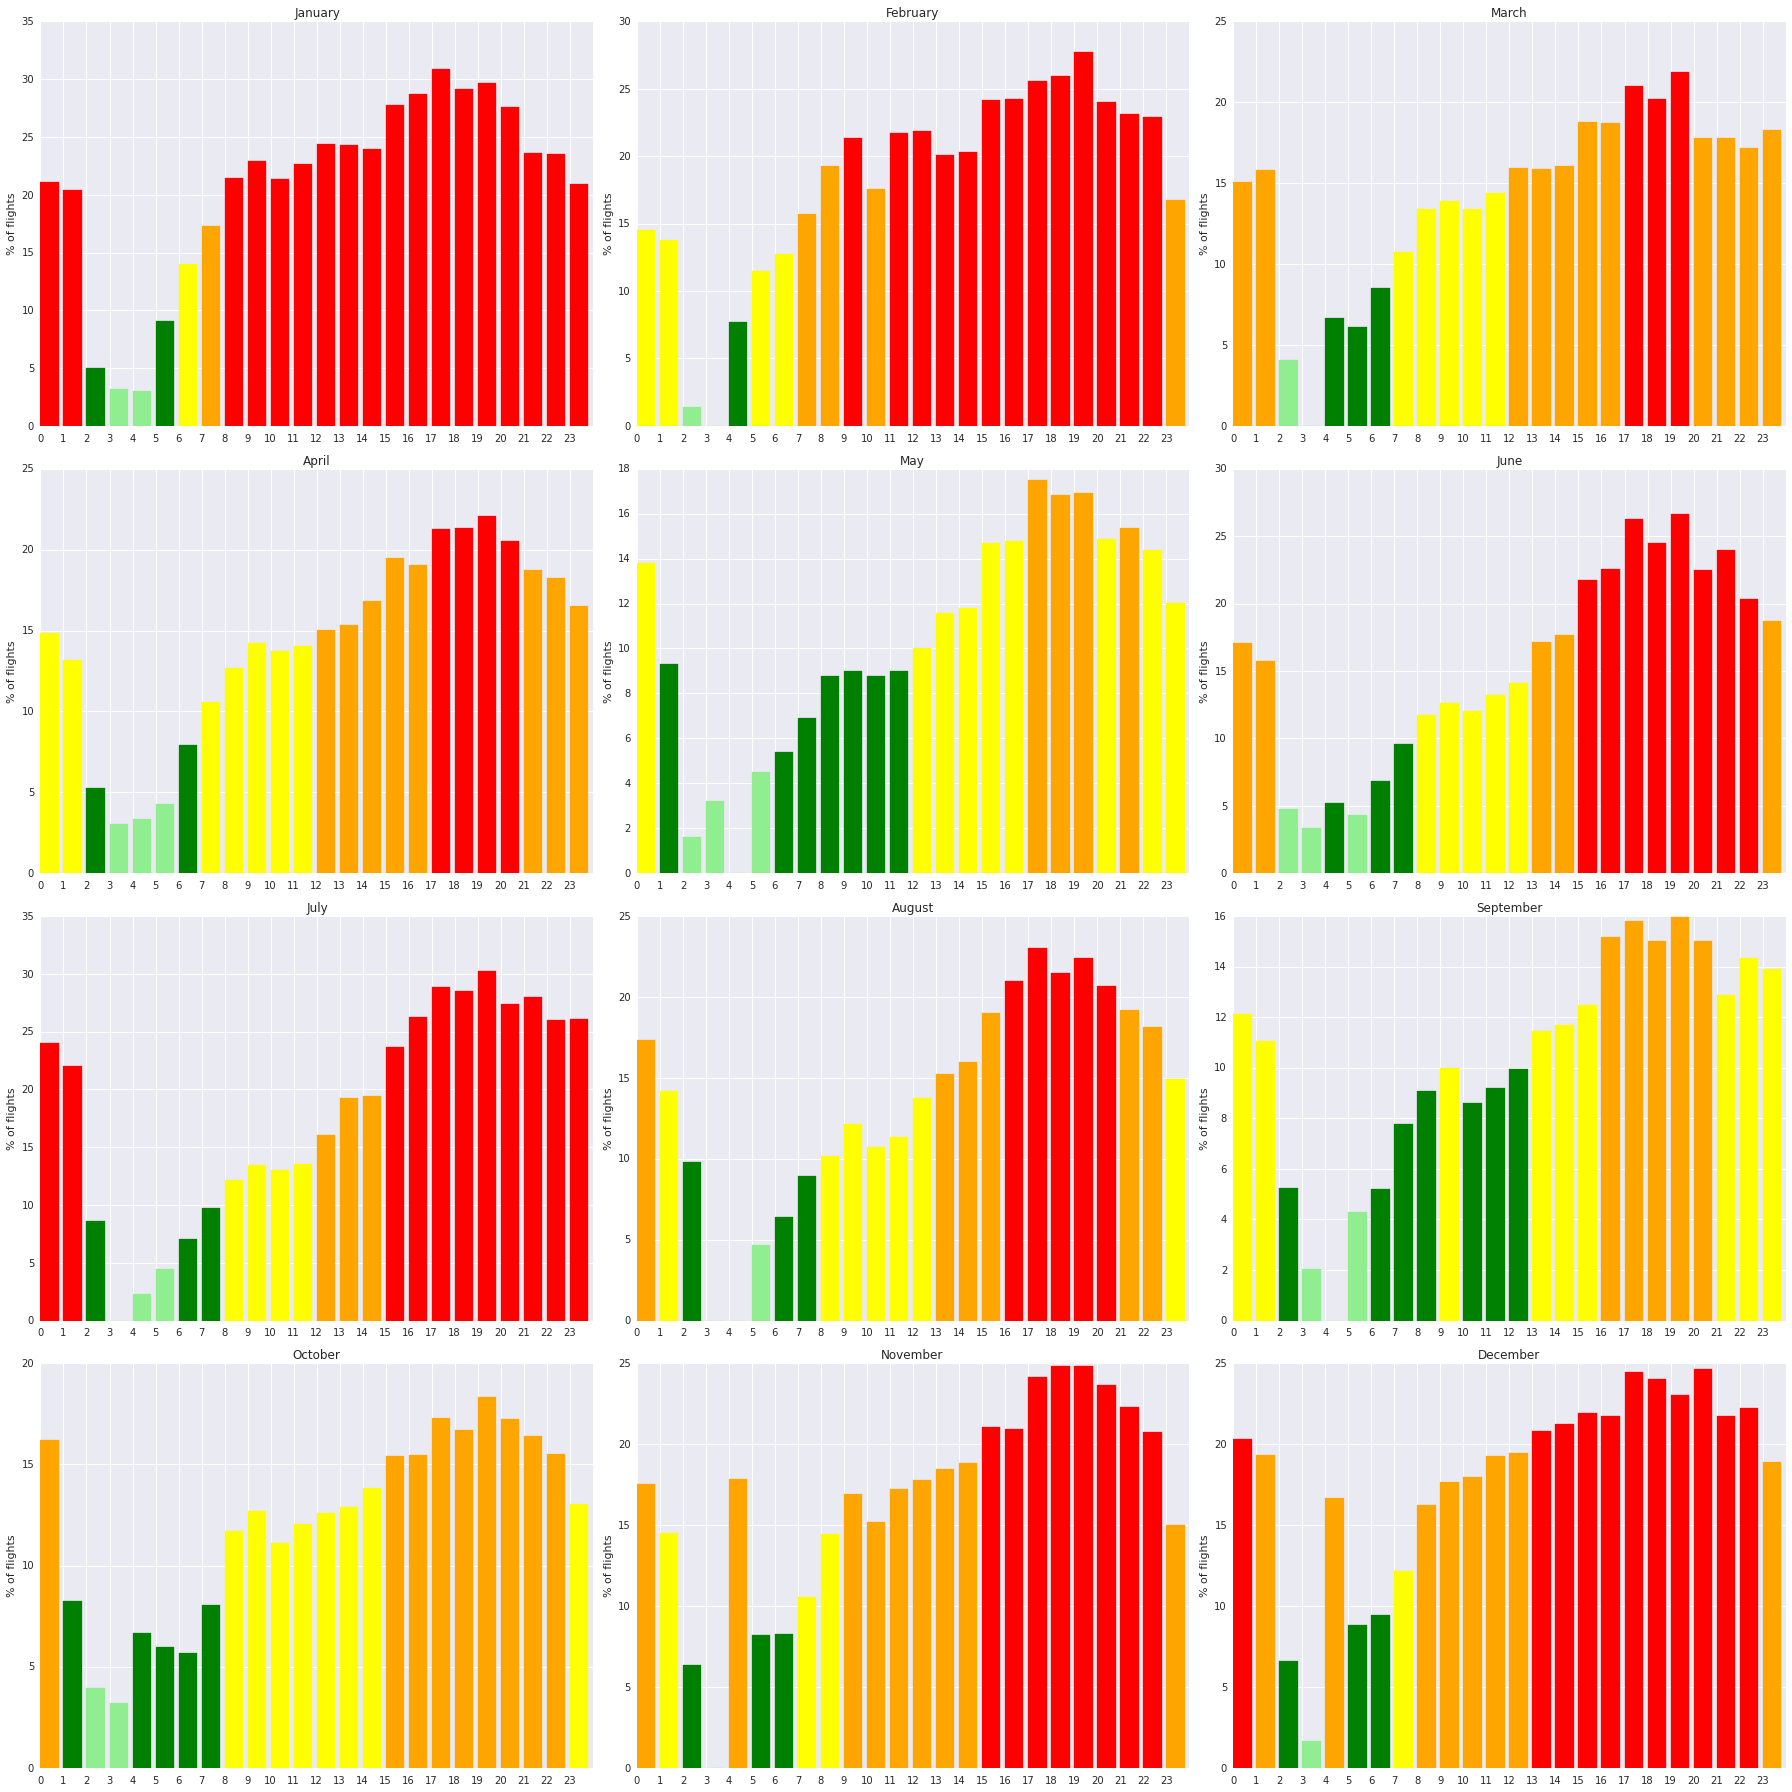

In [54]:
# df_hour_day is the dataframe with the hour of day column (with the cast to int) we have computed in the Question 3.3:
#df_hour_day = df.withColumn('hour_of_day', ((df.scheduled_departure_time/100).cast('int'))%24)
# to compute the delayed flights we create a new dataframe which is the result of the df_hour_day + one additional column:
# 'is_delay' is a column with 'boolean' values: 
# 1 to signal that the flight is in delay (arrived more then 15 minutes later)
# 0 otherwise
df_hour_day_with_delay = df_hour_day.withColumn('is_delay', func.when(df["arrival_delay"] >= 15, 1).otherwise(0))


### globally aggregates ###

# QUERY
# for each hour of day (group by hour of day) we aggregate the percentage of delays, which is computed as the 
# count of all the flights with the 'is_delay' column set to 1, divided by the total number of rows in the group.
statistic_day = df_hour_day_with_delay.groupBy(['hour_of_day'])\
                 .agg((100*func.sum('is_delay')/func.count('*')).alias('delay_ratio'))\
                 .orderBy('hour_of_day')
        
        
# PRINT & COLLECT
statistic_day.show()
hourly_delay = statistic_day.collect()


# PLOT
plt.figure(figsize=(15,8))
bars = plt.bar([x for x in range(len(hourly_delay))], [x[1] for x in hourly_delay])
for i in range(0, len(bars)):
    color = 'red'
    if hourly_delay[i][1] < 5:
        color = 'lightgreen'
    elif hourly_delay[i][1] < 10:
        color = 'green'
    elif hourly_delay[i][1] < 15:
        color = 'yellow'
    elif hourly_delay[i][1] < 20:
        color = 'orange'

    bars[i].set_color(color)
patch1 = mpatches.Patch(color='lightgreen', label='delay ratio < 5%')
patch2 = mpatches.Patch(color='green', label='delay ratio < 10%')
patch3 = mpatches.Patch(color='yellow', label='delay ratio < 15%')
patch4 = mpatches.Patch(color='orange', label='delay ratio < 20%')
patch5 = mpatches.Patch(color='red', label='delay ratio >= 20%')
plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks([x for x in range(len(hourly_delay))], [x for x in range(len(hourly_delay))])
plt.xlim(0, 24)
plt.title('Percentage of delayed flights per hour')
plt.ylabel('% of delayed flights')
plt.show()

pdf_delay_ratio_per_hour = pd.DataFrame(data=hourly_delay)





### monthly aggregates ###

# QUERY
statistic_day = df_hour_day_with_delay.groupBy(df_hour_day_with_delay.month, 'hour_of_day')\
                 .agg((100*func.sum('is_delay')/func.count('*')).alias('delay_ratio'))\
                 .orderBy(df_hour_day_with_delay.month, 'hour_of_day')


# PRINT
statistic_day.show()


# PLOT
nr = 4
nc = 3
plt.figure(figsize=(25, 25))
for i in range(12):
    monthly_counts = statistic_day[df.month == i+1].select('delay_ratio').collect()
    plt.subplot(nr, nc, i+1)
    bars = plt.bar([x for x in range(len(monthly_counts))], [x[0] for x in monthly_counts])
    for j in range(0, len(bars)):
        color = 'red'
        if monthly_counts[j][0] < 5:
            color = 'lightgreen'
        elif monthly_counts[j][0] < 10:
            color = 'green'
        elif monthly_counts[j][0] < 15:
            color = 'yellow'
        elif monthly_counts[j][0] < 20:
            color = 'orange'

        bars[j].set_color(color)
        
    plt.ylabel('% of delayed flights')
    plt.title(months[i])
    plt.xticks([p for p in range(len(monthly_counts))], [p for p in range(len(monthly_counts))])
    plt.xlim(0, len(monthly_counts))

plt.tight_layout()
plt.show()

On the x axis are reported the hours of the day (0-24), on the y the percentage of delayed flights.<br>
We have used colors to better evidence the difference between the different plots<br>
In order to compute the total number of flights for each time interval it has been considered the 'scheduled *departure* time'.<br>
Looking at the globaly aggregated plot it's clear that between 3am and 4am there is a lower probability of experiencing delay, this was expected as a consequence of what we have said before: the number of flights at that hour was very low.<br>
However, this is not exactly true for all the night flights; in fact, between the 22 and the 2am, despite the amount of flights is not as high as it is at 7am, the probability of delay is still around 0.15.<br>
The probability of delay, in fact, may depend not only on the "departure time" (which is what we have considered in the Question 3.3), but also on the "arrival time" and on the arrival airport.<br>
Anyhow, we can see that the delay probability changes also depending on the month. For example in May, September and October we cannot see any red bar, which implies that the delay is always lower then the 20% (those probably are the best month to fly!).

### Question 4.2
<div class="alert alert-info">
You will realize that saying *"at 4 A.M. there is a very low chance of a flight being delayed"* is not giving you a full picture of the situation. Indeed, it might be true that there is very little probability for an early flight to be delayed, but if it does, the delay might be huge, like 6 hours!  

<ul></ul>

Then, the question is: **which hours of the day are characterized by the largest mean delay?** (you can consider the median too)  

Plot a Bar chart and explain it.  

</div>

+-----------+-------------------+
|hour_of_day| avg(arrival_delay)|
+-----------+-------------------+
|          0|  4.631536068730559|
|          1| 2.7302062017944277|
|          2|-2.7850566572237963|
|          3|-2.7652329749103943|
|          4|0.29583333333333334|
|          5|0.26633813495072023|
|          6| 0.6106762748130248|
|          7| 1.7366349096338727|
|          8|  2.807898359028414|
|          9| 3.4053052919247278|
|         10|   3.44393544676388|
|         11|  4.090233343140837|
|         12|  4.496245367107028|
|         13|  5.230250273257823|
|         14|  5.889517094356155|
|         15|  7.594280213778955|
|         16|  8.184353093179144|
|         17|  9.476074194526362|
|         18|  9.354247292912708|
|         19|  9.966784652413988|
+-----------+-------------------+
only showing top 20 rows



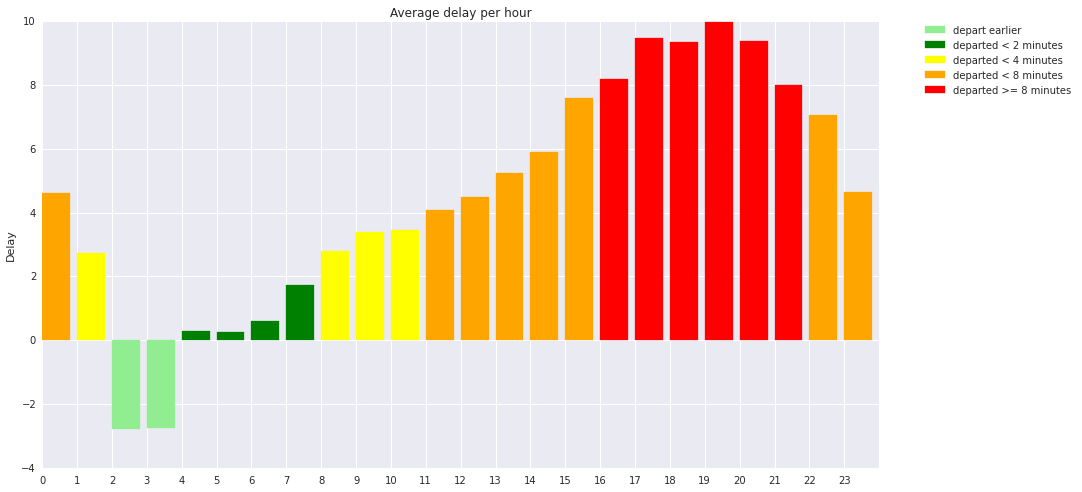

+-----+-----------+-------------------+
|month|hour_of_day| avg(arrival_delay)|
+-----+-----------+-------------------+
|    1|          0|  6.415026833631485|
|    1|          1|  7.117715617715618|
|    1|          2| -3.625531914893617|
|    1|          3|-3.1333333333333333|
|    1|          4|-2.6666666666666665|
|    1|          5| 1.7713097713097714|
|    1|          6|   4.59252893898802|
|    1|          7|  6.011113016635226|
|    1|          8|  8.370988612836438|
|    1|          9|  8.673068317422434|
|    1|         10|  8.868493150684932|
|    1|         11|  9.248729351969505|
|    1|         12| 10.287326453337293|
|    1|         13| 10.682596464418435|
|    1|         14| 10.925561005251964|
|    1|         15|  13.10922072623419|
|    1|         16|  14.23614133660428|
|    1|         17| 15.379452244276921|
|    1|         18|  14.25485610832422|
|    1|         19| 14.024683572812036|
+-----+-----------+-------------------+
only showing top 20 rows



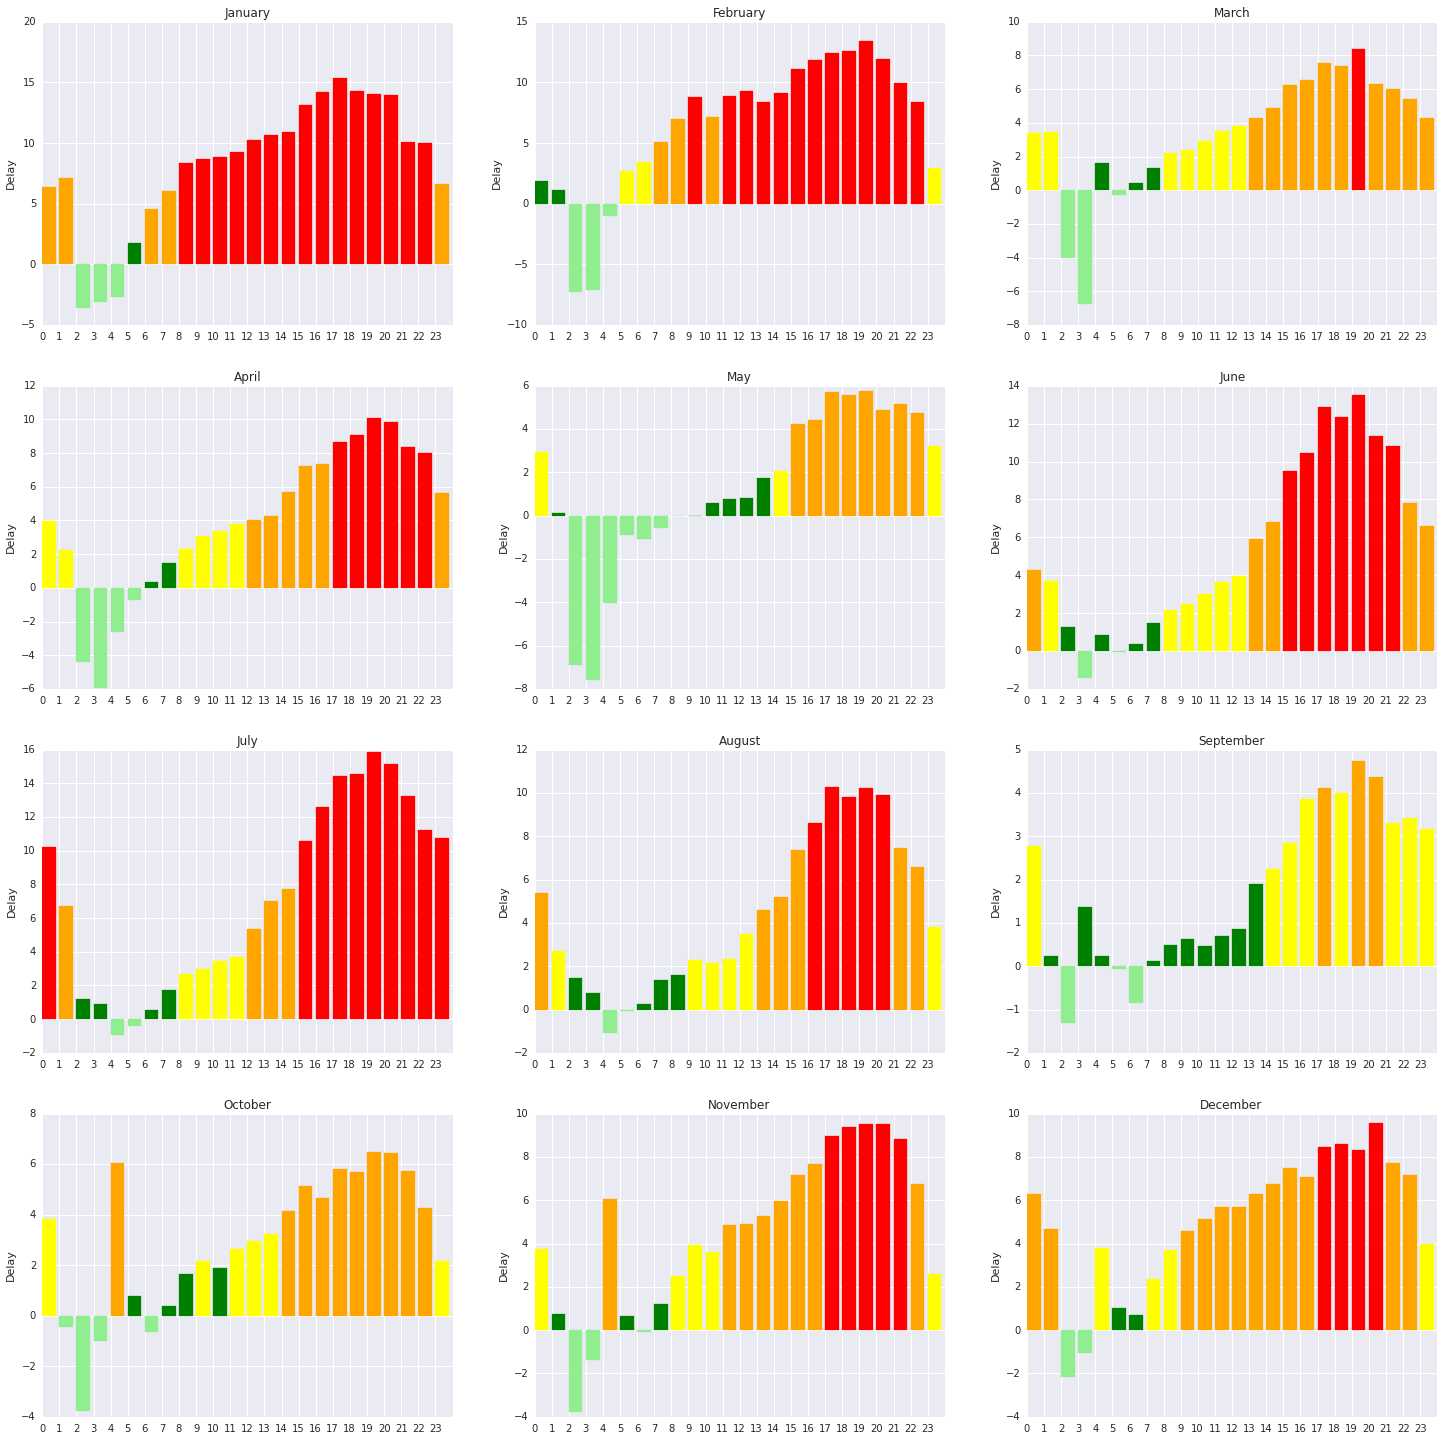

In [6]:
# df_hour_day is the dataframe with the hour of day column (with the cast to int) we have computed in the Question 3.3:
#df_hour_day = df.withColumn('hour_of_day', ((df.scheduled_departure_time/100).cast('int'))%24)
#months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

### globally aggregates ###

# QUERY
# for globally aggregates we simply grouped by 'hour of day' and computed the average of the delays in arrival delay
hourly_delays = df_hour_day.groupBy('hour_of_day').avg('arrival_delay').orderBy('hour_of_day')


# PRINT & COLLECT
hourly_delays.show()
hourly_delays = hourly_delays.collect()

    
# PLOT
plt.figure(figsize=(15,8))
bars = plt.bar([x for x in range(len(hourly_delays))], [x[1] for x in hourly_delays])
for i in range(0, len(bars)):
    color = 'red'
    if hourly_delays[i][1] < 0:
        color = 'lightgreen'
    elif hourly_delays[i][1] < 2:
        color = 'green'
    elif hourly_delays[i][1] < 4:
        color = 'yellow'
    elif hourly_delays[i][1] < 8:
        color = 'orange'

    bars[i].set_color(color)
patch1 = mpatches.Patch(color='lightgreen', label='depart earlier')
patch2 = mpatches.Patch(color='green', label='departed < 2 minutes')
patch3 = mpatches.Patch(color='yellow', label='departed < 4 minutes')
patch4 = mpatches.Patch(color='orange', label='departed < 8 minutes')
patch5 = mpatches.Patch(color='red', label='departed >= 8 minutes')
plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xticks([x for x in range(len(hourly_delays))], [x for x in range(len(hourly_delays))])
plt.xlim(0, 24)
plt.title('Average delay per hour')
plt.ylabel('Delay')
plt.show()

# preparing data for next cell
pdf_mean_delay_per_hour = pd.DataFrame(data=hourly_delays)




### monthly aggregates ###

# QUERY
# since we want to compute the monthly aggregates, we group by month and hour of day, and then compute the avg delay on each group
# then we order with respect to the month and the hour
hourly_delays = df_hour_day.groupBy(df_hour_day.month, 'hour_of_day').avg('arrival_delay').orderBy(df_hour_day.month, 'hour_of_day')


# PRINT
hourly_delays.show()


# PLOT
nr = 4
nc = 3
plt.figure(figsize=(25, 25))
for i in range(12):
    monthly_counts = hourly_delays[df.month == i+1].select('avg(arrival_delay)').collect()
    plt.subplot(nr, nc, i+1)
    bars = plt.bar([x for x in range(len(monthly_counts))], [x[0] for x in monthly_counts])
    for j in range(0, len(bars)):
        color = 'red'
        if monthly_counts[j][0] < 0:
            color = 'lightgreen'
        elif monthly_counts[j][0] < 2:
            color = 'green'
        elif monthly_counts[j][0] < 4:
            color = 'yellow'
        elif monthly_counts[j][0] < 8:
            color = 'orange'
        bars[j].set_color(color)
    plt.ylabel('Delay')
    plt.title(months[i])
    plt.xticks([p for p in range(len(monthly_counts))], [p for p in range(len(monthly_counts))])
    plt.xlim(0, len(monthly_counts))

plt.show()

On the x axis are reported the hours of the day (0-24), on the y the mean delayed in minutes.<br>
The scheduled departure time has been considered to compute the total number of flights for each time interval.<br>
Here we can see that between the 2am and the 4am the *arrival delay is negative*! This means that the flight is landed earlier.<br>
The hours of the day which are characterized by the highest mean delay are the ones between 17 and 21.<br>
Also in this case we have produced the monthly aggregated plot to better analyze the percentage of delayed flights over different months. As we have seen before, May, September and October were the months with the lower probability of experiencing a delay. Also in this case we can see that the those are also the months where the night flights arrive mostly earlier.
__________________________________________________________________________________________________________________

With data of year 1994, the flight from 3AM to 4AM often depart earlier than in their schedule. The flights in the morning have less delay then in the afternoon and evening.

So, an attentive student should notice here that we have somehow a problem with the definition of delay! Next, we will improve how to represent and visualize data to overcome this problem.

**NOTE**: the following piece of code assumes you correctly answered the previous questions. The naming convention of the DataFrames we use next should be clear enough for you to produce them by answering the questions above.

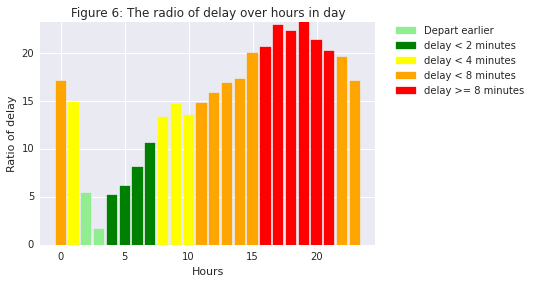

In [28]:
#pdf2 = pd.DataFrame(data=mean_delay_per_hour.collect())
plt.xlabel("Hours")
plt.ylabel("Ratio of delay")
plt.title('Figure 6: The radio of delay over hours in day')
plt.grid(True,which="both",ls="-")
bars = plt.bar(pdf_delay_ratio_per_hour[0], pdf_delay_ratio_per_hour[1], align='center', edgecolor = "black")
for i in range(0, len(bars)):
    color = 'red'
    if pdf_mean_delay_per_hour[1][i] < 0:
        color = 'lightgreen'
    elif pdf_mean_delay_per_hour[1][i] < 2:
        color = 'green'
    elif pdf_mean_delay_per_hour[1][i] < 4:
        color = 'yellow'
    elif pdf_mean_delay_per_hour[1][i] < 8:
        color = 'orange'

    bars[i].set_color(color)
        
patch1 = mpatches.Patch(color='lightgreen', label='Depart earlier')
patch2 = mpatches.Patch(color='green', label='delay < 2 minutes')
patch3 = mpatches.Patch(color='yellow', label='delay < 4 minutes')
patch4 = mpatches.Patch(color='orange', label='delay < 8 minutes')
patch5 = mpatches.Patch(color='red', label='delay >= 8 minutes')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.margins(0.05, 0)
plt.show()

In the new figure (Figure 6), we have more information in a single plot. The flights in 3AM to 4AM have very low probability of being delayed, and actually depart earlier than their schedule. In contrast, the flights in the 4PM to 8PM range have higher chances of being delayed: in more than 50% of the cases, the delay is 8 minutes or more.

This example shows us that the way representing results are also important.


### Question 4.3

<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over days in a month. Discuss your findings from the figure.
</div>

+------------+------------------+
|day_of_month|       delay_ratio|
+------------+------------------+
|           1|14.879121138182633|
|           2|15.071630875763267|
|           3|14.854337850816348|
|           4|14.438692082007568|
|           5| 16.99233477612915|
|           6| 16.37503662467038|
|           7|16.580918645839382|
|           8|16.666861970774693|
|           9|18.872040311153185|
|          10|18.175997932476566|
|          11|14.892493705109015|
|          12| 16.77401469842281|
|          13|17.829819540968288|
|          14| 16.84439304746021|
|          15|17.487129327562275|
|          16|17.532135188398975|
|          17|16.995039146074813|
|          18| 17.34179719319478|
|          19|14.538331278063287|
|          20| 17.57137347933295|
+------------+------------------+
only showing top 20 rows



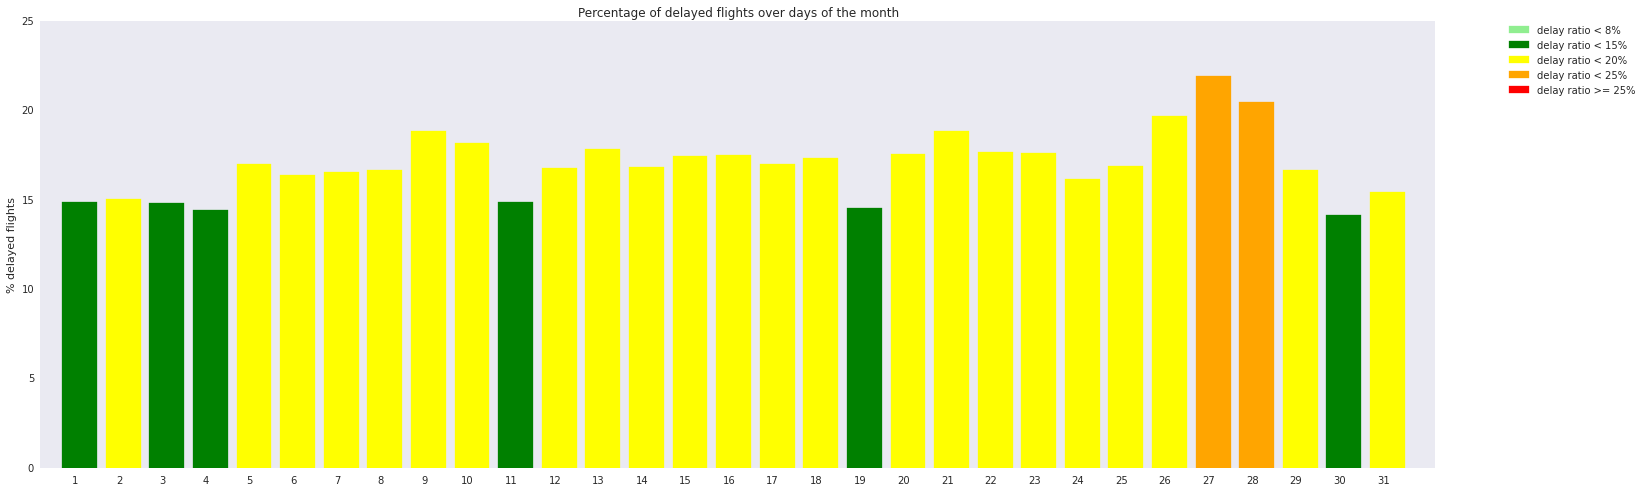

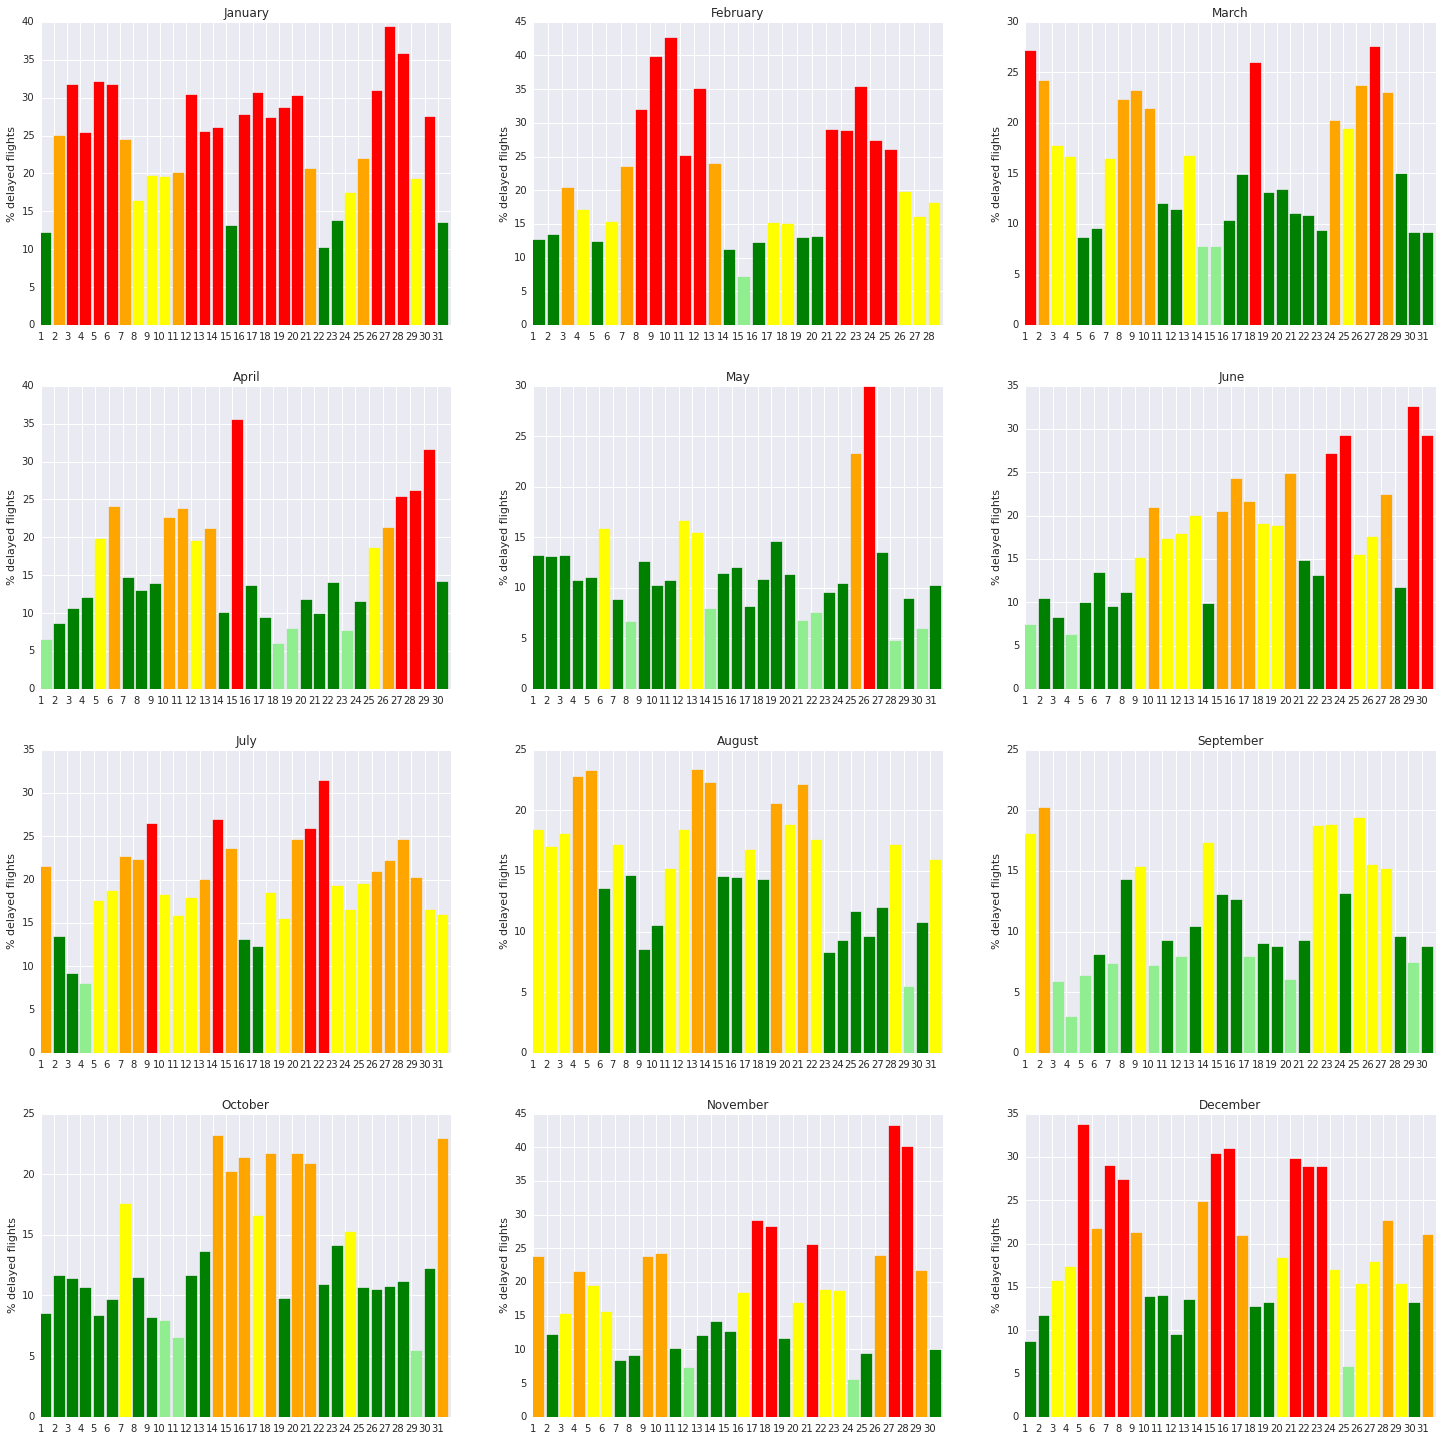

In [64]:
# to compute the delayed flights we create a new dataframe which is the result of the df_hour_day + one additional column:
# 'is_delay' is a column with 'boolean' values: 
# 1 to signal that the flight is in delay (arrived more then 15 minutes later)
# 0 otherwise
df_with_delay = df.withColumn('is_delay', func.when(df["arrival_delay"] >= 15, 1).otherwise(0))


### global aggregate ###

# QUERY
# for each day of month (group by day of month) we aggregate the percentage of delays, which is computed as the 
# count of all the flights with the 'is_delay' column set to 1, divided by the total number of rows in the group.
statistic_day = df_with_delay.groupBy(['day_of_month'])\
                 .agg((100*func.sum('is_delay')/func.count('*')).alias('delay_ratio'))\
                 .orderBy('day_of_month')


# PRINT & COLLECT
statistic_day.show()
delay_day_of_month = statistic_day.collect()


# PLOT
plt.figure(figsize=(25,8))
bars = plt.bar([x for x in range(len(delay_day_of_month))], [x[1] for x in delay_day_of_month])
for j in range(0, len(bars)):
    color = 'red'
    if delay_day_of_month[j][1] < 8:
        color = 'lightgreen'
    elif delay_day_of_month[j][1] < 15:
        color = 'green'
    elif delay_day_of_month[j][1] < 20:
        color = 'yellow'
    elif delay_day_of_month[j][1] < 25:
        color = 'orange'
    bars[j].set_color(color)
patch1 = mpatches.Patch(color='lightgreen', label='delay ratio < 8%')
patch2 = mpatches.Patch(color='green', label='delay ratio < 15%')
patch3 = mpatches.Patch(color='yellow', label='delay ratio < 20%')
patch4 = mpatches.Patch(color='orange', label='delay ratio < 25%')
patch5 = mpatches.Patch(color='red', label='delay ratio >= 25%')
plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('% delayed flights')
plt.title('Percentage of delayed flights over days of the month')
plt.xticks([x+0.3 for x in range(31)], [x+1 for x in range(31)])
plt.xlim(0-0.5, 31+0.5)

plt.grid()
plt.show()



### monthly aggregates ###

# QUERY
# since we want to compute the monthly aggregates, we group by month and day of month, and then we compute the avg delay on each group
# then we order with respect to the month and the hour
statistic_day = df_with_delay.groupBy([df.month, 'day_of_month'])\
                 .agg((100*func.sum('is_delay')/func.count('*')).alias('delay_ratio'))\
                 .orderBy(df.month, 'day_of_month')

# PLOT
nr = 4
nc = 3
plt.figure(figsize=(25, 25))
for i in range(12):
    monthly_counts = statistic_day[df.month == i+1].select('delay_ratio').collect()
    plt.subplot(nr, nc, i+1)
    bars = plt.bar([x for x in range(len(monthly_counts))], [x[0] for x in monthly_counts])
    for j in range(0, len(bars)):
        color = 'red'
        if monthly_counts[j][0] < 8:
            color = 'lightgreen'
        elif monthly_counts[j][0] < 15:
            color = 'green'
        elif monthly_counts[j][0] < 20:
            color = 'yellow'
        elif monthly_counts[j][0] < 25:
            color = 'orange'

        bars[j].set_color(color)
    plt.ylabel('% delayed flights')
    plt.title(months[i])
    plt.xticks([p for p in range(len(monthly_counts))], [p+1 for p in range(len(monthly_counts))])
    plt.xlim(0, len(monthly_counts))

plt.show()

Also in this case we decided to produce one global plot and one plot with monthly aggregate to allow a better analysis.<br><br>
For each plot, on the x axis are reported the days of the month (0-31), on the y the percentage of delayed flights (cumulated globally in the first chart, and monthly for the others).<br>
Looking at the global aggregate plot we can say that in general the probability of experiencing a delay (in average on the entire year) is between 15% and 20% for each day of the month. However, with a deeper analysis, we can actually see that it can really vary depending on the month: there are peacks up to 40% in some days of January (27) and February (10), as well as days in which the probability of delay goes down to less then 5%: 4 September, 24 November and 25 December. If we come back to the previous analysis, we can notice that those were days in which the number of flights was lower respect to the average!

### Question 4.4

<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over days in a week. Discuss your findings from the figure.
</div>

+-----------+------------------+
|day_of_week|       delay_ratio|
+-----------+------------------+
|          1|16.329197122851284|
|          2|15.330349542385518|
|          3|18.151213428039913|
|          4|19.779731403776527|
|          5|19.487020495495194|
|          6|14.140914353932786|
|          7|15.609574290706359|
+-----------+------------------+



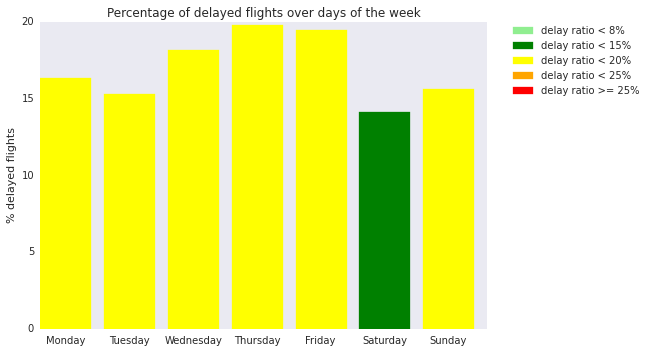

+-----+-----------+------------------+
|month|day_of_week|       delay_ratio|
+-----+-----------+------------------+
|    1|          1|22.551970718333546|
|    1|          2| 23.63875228575994|
|    1|          3|30.503718003718003|
|    1|          4|31.639520315017005|
|    1|          5|26.673328455951893|
|    1|          6| 14.19632569453335|
|    1|          7| 22.67048020472678|
|    2|          1|20.363668461470564|
|    2|          2| 20.08523581318856|
|    2|          3|25.049592631951825|
|    2|          4| 26.25972598855036|
|    2|          5|20.787357232106718|
|    2|          6|19.993677263835924|
|    2|          7|17.056787351482832|
|    3|          1|14.497175535253504|
|    3|          2| 16.44405241935484|
|    3|          3|15.164116828929068|
|    3|          4| 16.63006310639126|
|    3|          5|18.451219512195124|
|    3|          6|14.156620639959492|
+-----+-----------+------------------+
only showing top 20 rows



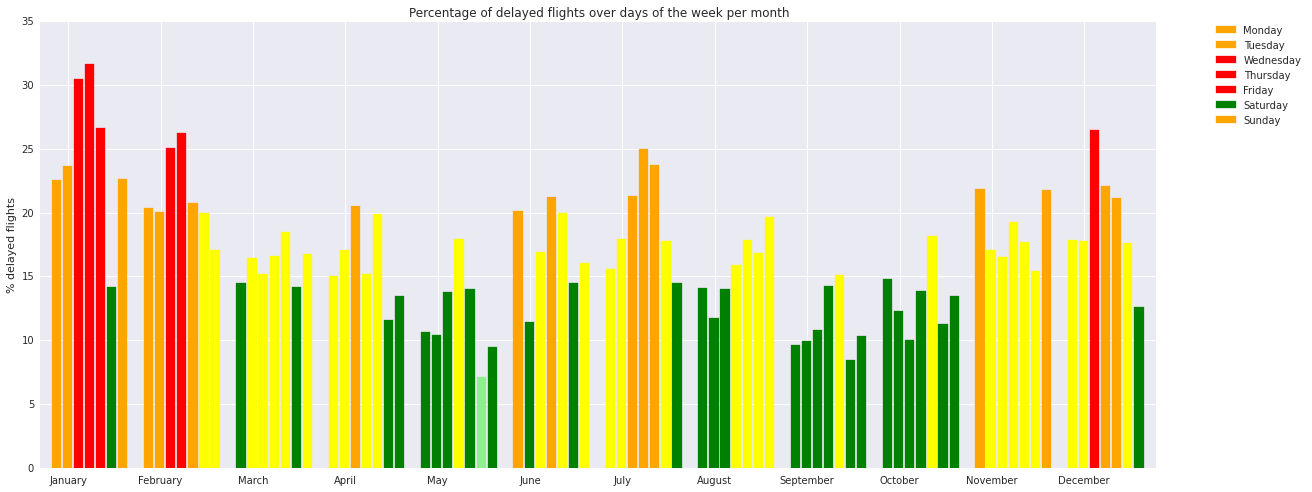

In [67]:
# here we use the df_with_delay dataframe generated in the previous cell, the code is reported also here for clarity reasons
# df_with_delay = df.withColumn('is_delay', func.when(df["arrival_delay"] >= 15, 1).otherwise(0))

days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

### global aggregate ###

# QUERY
# for each day of week (group by day of week) we aggregate the percentage of delays, which is computed as the 
# count of all the flights with the 'is_delay' column set to 1, divided by the total number of rows in the group.
statistic_day = df_with_delay.groupBy(['day_of_week'])\
                 .agg((100*func.sum('is_delay')/func.count('*')).alias('delay_ratio'))\
                 .orderBy('day_of_week')
        
        
# PRINT & COLLECT
statistic_day.show()
delay_day_of_week = statistic_day.collect()


# PLOT
bars = plt.bar([x for x in range(len(delay_day_of_week))], [x[1] for x in delay_day_of_week])
for j in range(0, len(bars)):
    color = 'red'
    if delay_day_of_week[j][1] < 8:
        color = 'lightgreen'
    elif delay_day_of_week[j][1] < 15:
        color = 'green'
    elif delay_day_of_week[j][1] < 20:
        color = 'yellow'
    elif delay_day_of_week[j][1] < 25:
        color = 'orange'
    bars[j].set_color(color)
patch1 = mpatches.Patch(color='lightgreen', label='delay ratio < 8%')
patch2 = mpatches.Patch(color='green', label='delay ratio < 15%')
patch3 = mpatches.Patch(color='yellow', label='delay ratio < 20%')
patch4 = mpatches.Patch(color='orange', label='delay ratio < 25%')
patch5 = mpatches.Patch(color='red', label='delay ratio >= 25%')
plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.ylabel('% delayed flights')
plt.title('Percentage of delayed flights over days of the week')
plt.xticks([x+0.4 for x in range(len(days_of_week))], days_of_week)

plt.grid()
plt.show()



### monthly aggregates ###

# QUERY
# since we want to compute the monthly aggregates, we group by month first and day of week then, 
# and then we compute the avg delay on each group
# then we order with respect to the month and the hour
statistic_day = df_with_delay.groupBy(['month', 'day_of_week'])\
                 .agg((100*func.sum('is_delay')/func.count('*')).alias('delay_ratio'))\
                 .orderBy('month', 'day_of_week')
        
        
# PRINT & COLLECT
statistic_day.show()
days_count = statistic_day.collect()


# PLOT
pos = list(range(len(months)))
width = 0.12

fig, ax = plt.subplots(figsize=(20,8))
for d in range(len(days_of_week)):
    data_values = []
    for m in range(len(months)):
        data_values.append(days_count[m*len(days_of_week)+d][2])
    bars = plt.bar([p + width*d for p in pos], data_values, width-0.02)
    for j in range(0, len(bars)):
        color = 'red'
        if data_values[j] < 8:
            color = 'lightgreen'
        elif data_values[j] < 15:
            color = 'green'
        elif data_values[j] < 20:
            color = 'yellow'
        elif data_values[j] < 25:
            color = 'orange'
        bars[j].set_color(color)
    
ax.set_ylabel('% delayed flights')
ax.set_title('Percentage of delayed flights over days of the week per month')
ax.set_xticks([p + 1.5 * width for p in pos])
ax.set_xticklabels(months)
plt.xlim(min(pos)-width, max(pos)+width*(len(days_of_week)+1))

plt.legend(days_of_week, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

The same analysis as before has been repeated for each day of the week, with both global and month aggregates.<br><br>
x->days of the week, y->percentage of delayed flights<br>
By looking at the globally aggregate plot we can confirm what we have said before: the delay probability varies between ~0.15 and ~0.20, with some evident variations depending on the day of the week: during the weekend (Saturday and Sunday) the dalay is lower than during the others day of the week, in particular with respect to Thursday and Friday. This was also expected because the number of flights during the weekend was lower then during the others day of the week.<br>
However, an important thing to notice is that here we can see how it really depends on the considered month! During the winter months, the average delay probability seems to be higher than during the other months (except for August).<br>
Anyhow, the delay percentage confirms what said globally, in most of the case is higher on Thursday and Friday, but there are some exception; for example in August and November the highest peacks are registered on Sunday.

### Question 4.5
<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over months in a year. Discuss your findings from the figure.
</div>

+-----+------------------+
|month|       delay_ratio|
+-----+------------------+
|    1|24.275411042771097|
|    2| 21.42347669232002|
|    3| 16.04280898979601|
|    4| 16.18879084074633|
|    5|11.835291637643437|
|    6|17.327956106825482|
|    7|19.398696522256476|
|    8|15.460023144145461|
|    9|11.516243057505784|
|   10|13.426382327218834|
|   11| 18.42947782367763|
|   12| 19.56167795019719|
+-----+------------------+



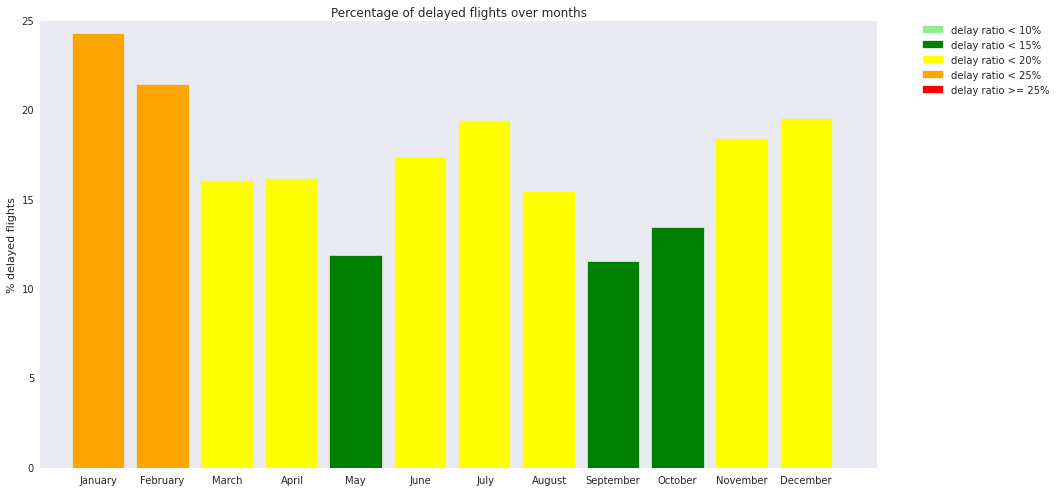

In [70]:
# here we use the df_with_delay dataframe generated in the cell 4.3, the code is reported also here for clarity reasons
# df_with_delay = df.withColumn('is_delay', func.when(df["arrival_delay"] >= 15, 1).otherwise(0))

# QUERY
# for each month (group by month) we aggregate the percentage of delays, which is computed as the 
# count of all the flights with the 'is_delay' column set to 1, divided by the total number of rows in the group.
statistic_day = df_with_delay.groupBy(['month'])\
                 .agg((100*func.sum('is_delay')/func.count('*')).alias('delay_ratio'))\
                 .orderBy('month')
        
# PRINT & COLLECT
statistic_day.show()
delay_month = statistic_day.collect()


# PLOT
plt.figure(figsize=(15,8))
bars = plt.bar([x for x in range(len(delay_month))], [x[1] for x in delay_month])
for j in range(0, len(bars)):
    color = 'red'
    if delay_month[j][1] < 10:
        color = 'lightgreen'
    elif delay_month[j][1] < 15:
        color = 'green'
    elif delay_month[j][1] < 20:
        color = 'yellow'
    elif delay_month[j][1] < 25:
        color = 'orange'
    bars[j].set_color(color)
patch1 = mpatches.Patch(color='lightgreen', label='delay ratio < 10%')
patch2 = mpatches.Patch(color='green', label='delay ratio < 15%')
patch3 = mpatches.Patch(color='yellow', label='delay ratio < 20%')
patch4 = mpatches.Patch(color='orange', label='delay ratio < 25%')
patch5 = mpatches.Patch(color='red', label='delay ratio >= 25%')
plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('% delayed flights')
plt.title('Percentage of delayed flights over months')
plt.xticks([x+0.4 for x in range(len(months))], [x for x in months])
plt.xlim(0-0.5, 12+0.5)

plt.grid()
plt.show()

To finish, the same analysis has been repeated also for each month of the year.<br>
Another time, on the x axis is reported the month, and on the y is reported the delay percentage.<br>
From this plot it's really evident what we had glimpsed before: the percentage of delayed flights depends on the month! The months with less delays are May and September, while the ones with the higher probability are January and February; in general, the winter months are the ones with highest delays.<br>
This suggest that the delays could be also correlated with the weather conditions!

We are ready now to draw some observations from our data, even if we have only looked at data coming from a year worth of flights:

- The probability for a flight to be delayed is low at the beginning or at the very end of a given months
- Flights on two first weekdays and on the weekend, are less likely to be delayed
- May and September are very good months for travelling, as the probability of delay is low (remember we're working on US data. Do you think this is also true in France?)

Putting things together, we can have a global picture of the whole year!

In [32]:
df_with_delay = df.withColumn('is_delay', func.when(df["arrival_delay"] >= 15, 1).otherwise(0))
statistic_day = df_with_delay.groupBy(['year','month', 'day_of_month', 'day_of_week'])\
    .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))

# assume that we do statistic on year 1994
statistic_day = statistic_day\
    .orderBy('year', 'month', 'day_of_month', 'day_of_week')
pdf = pd.DataFrame(data=statistic_day.collect())

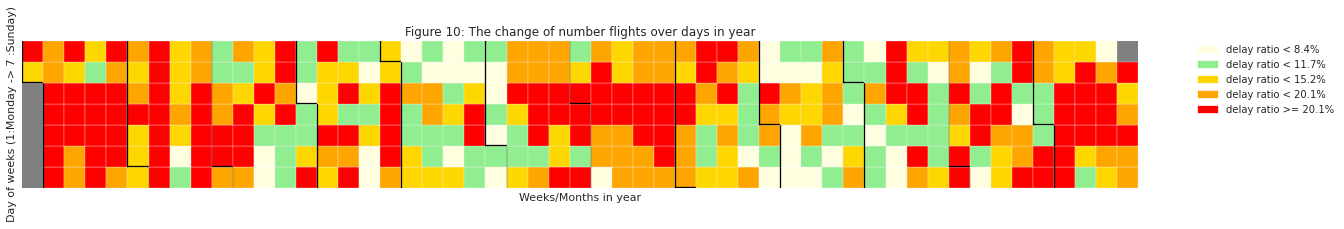

In [33]:
fig = plt.figure(figsize=(20,10))                                                             
ax = fig.add_subplot(1,1,1)     
plt.xlabel("Weeks/Months in year")
plt.ylabel("Day of weeks (1:Monday -> 7 :Sunday)")
plt.title('Figure 10: The change of number flights over days in year')
  
rec_size = 0.3
from matplotlib.patches import Rectangle
import datetime
num_days = len(pdf[0])
ax.patch.set_facecolor('gray')
ax.set_aspect('equal', 'box')
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())

for i in range(0, num_days):
    # extract information from the result
    year = pdf[0][i]
    month = pdf[1][i]
    day_of_month = pdf[2][i]
    day_of_week = pdf[3][i]
    day_of_year= datetime.date(year=year, month=month, day=day_of_month).timetuple()
    week_of_year = datetime.date(year=year, month=month, day=day_of_month).isocalendar()[1]
    
    # dealing with the week of the previous year
    if week_of_year == 52 and month == 1:
        week_of_year = 0
        
    # the coordinate of a day in graph
    X = week_of_year*rec_size
    Y = day_of_week*rec_size
    
    # use different colors to show the delay ratio
    color = 'white'
    if pdf[4][i] <= 0.084:
        color = 'lightyellow'
    elif pdf[4][i] <= 0.117:
        color = 'lightgreen'
    elif pdf[4][i] <= 0.152:
        color = 'gold'
    elif pdf[4][i] <= 0.201:
        color = 'orange'
    else:
        color = 'red'
    rect = plt.Rectangle((X - rec_size/2.0, Y - rec_size/2.0), rec_size, rec_size,
                      alpha=1, facecolor=color, edgecolor='whitesmoke')

    ax.add_patch(rect)
    
    # drawing boders to separate months
    if day_of_month <= 7:
        rect2 = plt.Rectangle((X -rec_size/2.0, Y - rec_size/2.0), 0.01, rec_size,
                      alpha=1, facecolor='black')
        ax.add_patch(rect2)
    if day_of_month == 1:
        rect2 = plt.Rectangle((X - rec_size/2.0, Y - rec_size/2.0), rec_size, 0.01,
                      alpha=1, facecolor='black')
        ax.add_patch(rect2)
ax.autoscale_view()

patch1 = mpatches.Patch(color='lightyellow', label='delay ratio < 8.4%')
patch2 = mpatches.Patch(color='lightgreen', label='delay ratio < 11.7%')
patch3 = mpatches.Patch(color='gold', label='delay ratio < 15.2%')
patch4 = mpatches.Patch(color='orange', label='delay ratio < 20.1%')
patch5 = mpatches.Patch(color='red', label='delay ratio >= 20.1%')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

### Question 4.6
<div class="alert alert-info">

What is the delay probability for the top 20 busiest airports?  


By drawing the flight volume of each airport and the associated delay probability in a single plot, we can observe the relationship between airports, number of flights and the delay.  

<div class="label label-success">HINT </div>  Function `<df_colum>.isin(<list>)` helps checking whether a value in column belongs to a list.
<ul></ul>
<div class="label label-success">SUGGESTION </div>  You can try with different chart type to have a better visualization.
</div>

Delay probability and flight volume for top busiest airports:
+-------+------+-------------------+
|airport| count|        delay_ratio|
+-------+------+-------------------+
|    MCO|153720|0.17871454592766067|
|    DCA|176115|0.16124691252874543|
|    PHL|186897|0.20326168959373345|
|    LAS|189920|0.17209877843302443|
|    BOS|199696|0.21722017466549154|
|    LGA|203362| 0.1854427080772219|
|    IAH|208591|0.16711171622936752|
|    EWR|233991| 0.2611980802680445|
|    SFO|235478|  0.184632959342274|
|    MSP|247980|0.13999112831679975|
|    CLT|259712|0.18741529078363725|
|    PIT|262939|0.19441011032977232|
|    DTW|276272|0.14818729368158917|
|    PHX|280560|0.16685201026518393|
|    DEN|285526| 0.1950330267646379|
|    STL|304409|0.16954820652477423|
|    LAX|306453|0.18532695062538138|
|    ATL|443074|0.20877099536420554|
|    DFW|516523|0.20272088561399976|
|    ORD|561461| 0.1556564035614228|
+-------+------+-------------------+



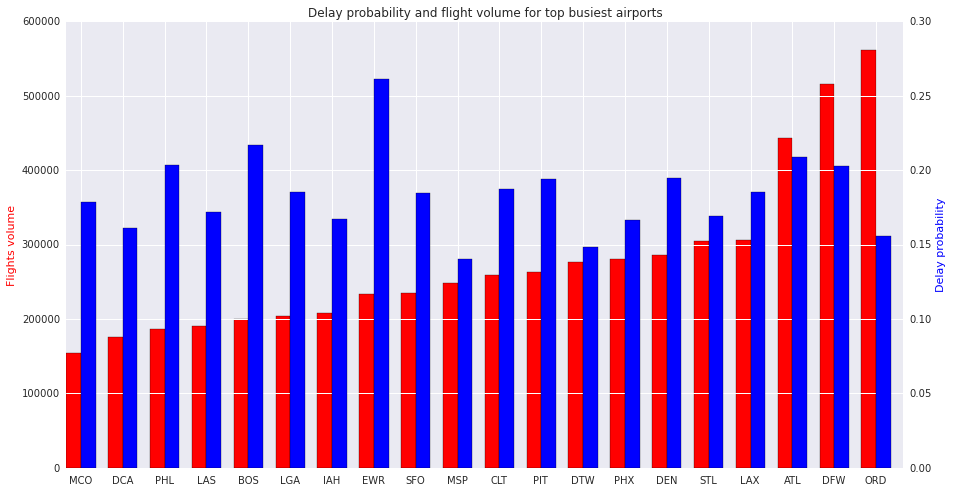

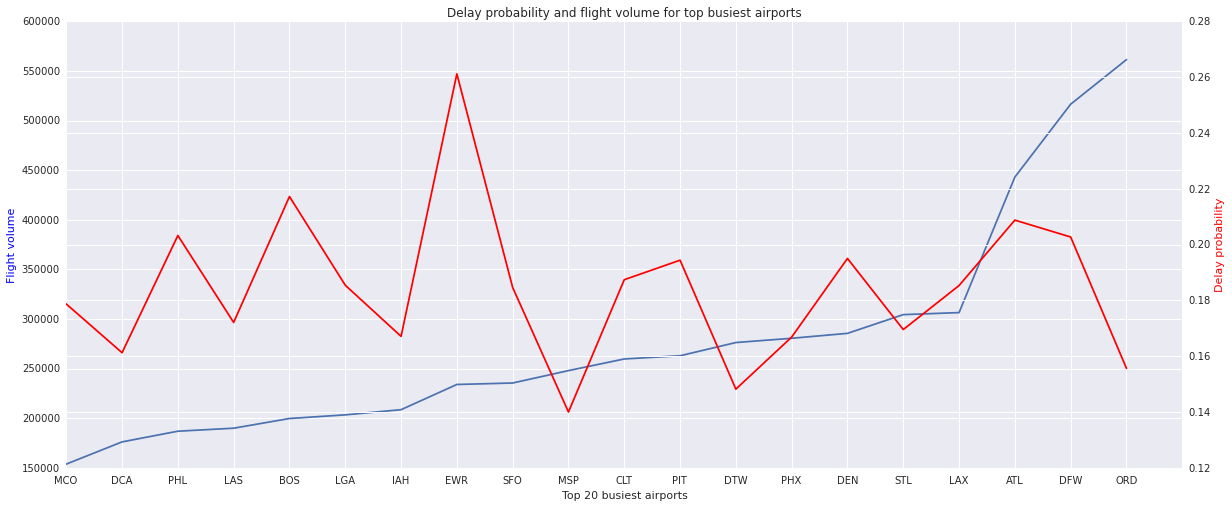

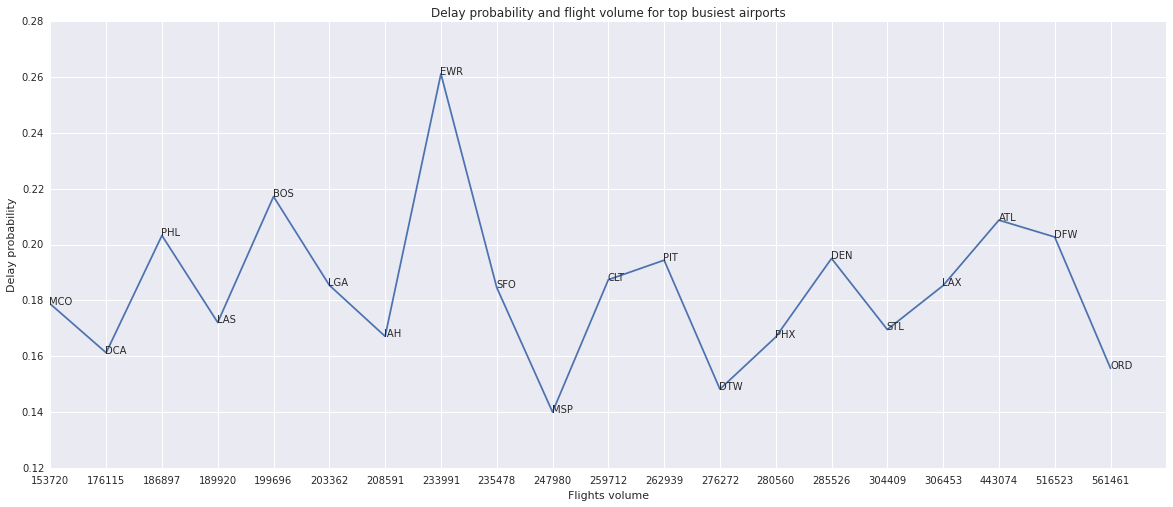

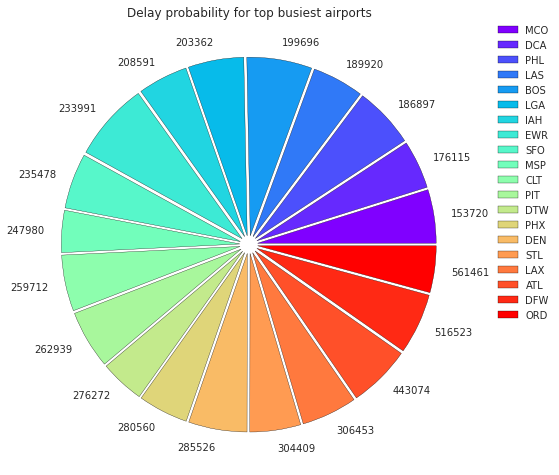

In [34]:
# here we reused the top_busiest_airport and df_airports dataframes computed in the cell 3.4
# it contains the top busiest airports ordered in descending order of number of flights
# the code is reported here for clarity reasons:

#df_airport = df.withColumn('airport', df.src_airport).union(df.withColumn('airport', df.dest_airport))
#top_busiest_airport = df_airport.groupBy('airport').count().orderBy('count', ascending=0)

# take the first 20 airports from the dataframe and put them into a list (to be used by the 'isin' function)
top_20 = top_busiest_airport.take(20)
top_20 = [x[0] for x in top_20]


# QUERY
# filter the df (with airport column) and add the is_delay column as we did also in the previous questions
df_with_delay = df_airport.filter(df_airport.airport.isin(top_20)).withColumn('is_delay', func.when((df["arrival_delay"] >= 15), 1).otherwise(0))
# then group by airport, and for each airport, compute the delay ratio
statistic_day = df_with_delay.groupBy('airport')\
                 .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))\
                 .orderBy('delay_ratio')


# PRINT & COLLECT
print('Delay probability and flight volume for top busiest airports:')
data = top_busiest_airport.join(statistic_day, on='airport').select('*').orderBy('count')
data.show()
data = data.collect()


# PLOT (bar chart)
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax.bar([x for x in range(len(data))], [x[1] for x in data], 0.35, color='r')
ax.set_ylabel('Flights volume', color='r')
ax2 = ax.twinx()
ax2.bar([x+0.35 for x in range(len(data))], [x[2] for x in data], 0.35, color='b')
ax2.set_ylabel('Delay probability', color='b')
plt.xticks([x+0.35 for x in range(len(data))], [x[0] for x in data])
plt.title('Delay probability and flight volume for top busiest airports')
plt.show()


# PLOT (line chart with x=airport, y1=flight volume, y2=delay)
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
ax.set_title('Delay probability and flight volume for top busiest airports')
ax.plot([x for x in range(len(data))], [x[1] for x in data])
ax.set_xlabel('Top 20 busiest airports')
ax.set_ylabel('Flight volume', color='b')
ax2 = ax.twinx()
ax2.plot([x for x in range(len(data))], [x[2] for x in data], c='r')
ax2.set_ylabel('Delay probability', color='r')
plt.xticks([x for x in range(len(data))], [x[0] for x in data])
plt.show()


# PLOT (line chart with x=flight volume and y=delay prob)
plt.figure(figsize=(20,8))
plt.plot([x for x in range(len(data))], [x[2] for x in data])
plt.xticks([x for x in range(len(data))], [x[1] for x in data])
for x in range(len(data)):
    plt.annotate('%s' % data[x][0], xy=(x, data[x][2]))
plt.title('Delay probability and flight volume for top busiest airports')
plt.ylabel('Delay probability')
plt.xlabel('Flights volume')
plt.show()

# PLOT (pie chart)
plt.figure(figsize=(8,8))
patches, _ = plt.pie([x[2] for x in data], 
        explode=[0.05 for _ in range(len(data))], 
        colors=cm.rainbow(np.linspace(0, 1, 20)), 
        labels=[x[1] for x in data])
plt.legend(patches, [x[0] for x in data], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Delay probability for top busiest airports')
plt.show()

Two line charts have been produced: (1) with x=flights_volume and y=delay_probability and (2) with two separated lines for volume and delay, and the airports on the x.<br>
One bar chart: x=airports, y=delay.<br>
One pie chart: a slice for each airport, with different size based on probability.<br>
<br>
Analyzing the different produced plot we can see that there is no evident correlation between the delay probability and the flight volume.<br>
Looking at the line chart (1) it was expected a monotonically increasing function: if the flights volume increases, it's expected that also the delay probability increase! But in this case it's not.<br>
In particular, the **EWR** airport is the one which registers the highest **delay probability**, with a value around 0.26; however, it's flight volume is around 234k flights per year, which is not even the half of the **ORD airport**, whose **flight volume** (the highest in the considered dataset) is 560k per year and has a delay probability of 0.16 (one of the lowest!).<br>
So this could mean that some of the companies are better organized than others, and, as a consequence, are able to manage bigger volumes of flights without experiencing high delays.

### Question 4.7

<div class="alert alert-info">
What is the percentage of delayed flights which belong to one of the top 20 busiest carriers?  
Comment the figure!

<ul></ul>
<div class="label label-success">SUGGESTION </div>  You can try with different chart type to have a better visualization.
</div>

Delay probability and flight volume for top busiest carriers:
+-------+------+-------------------+
|carrier| count|        delay_ratio|
+-------+------+-------------------+
|     AS|117475| 0.1596424771227921|
|     HP|177851|0.18625141269939444|
|     TW|258205|0.18212273193780135|
|     NW|482798| 0.1294806523639286|
|     CO|484834| 0.1955576547849367|
|     WN|565426|0.12829795587751536|
|     UA|638750| 0.1686528375733855|
|     AA|722277| 0.1752444006939166|
|     US|857906|0.18422298014001534|
|     DL|874526|0.18328443065157582|
+-------+------+-------------------+



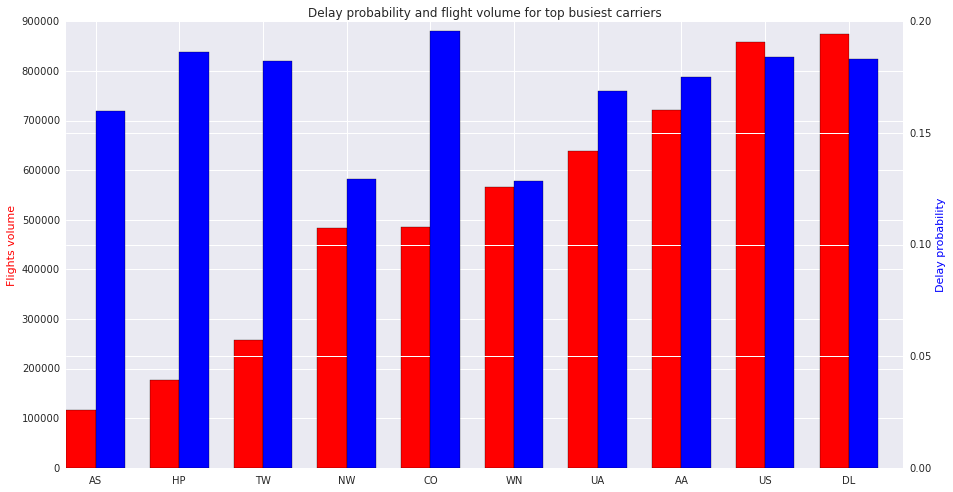

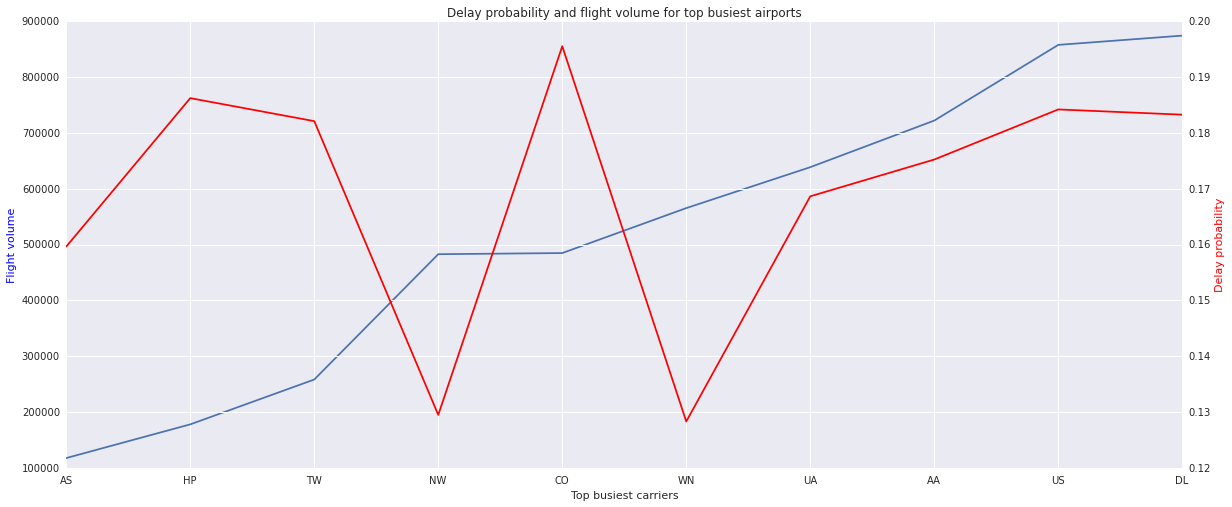

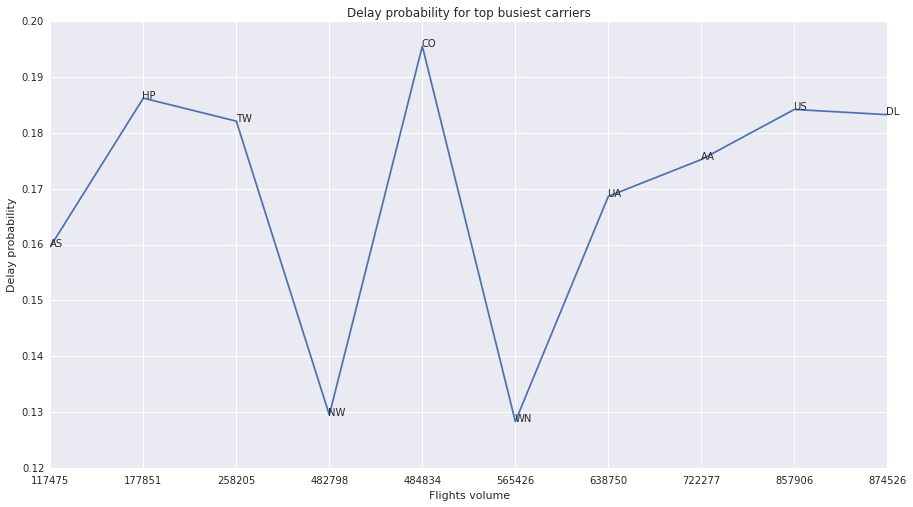

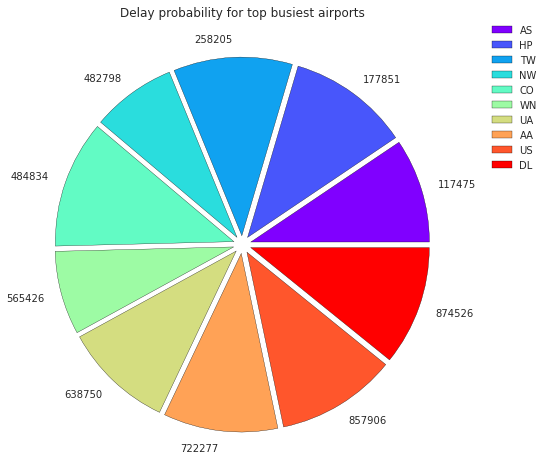

In [35]:
# here we reused the top_busiest_carriers dataframe computed in the cell 3.5
# it contains the top busiest carriers ordered in descending order of number of flights
# the code is reported here for clarity reasons:

# top_busiest_carriers = df.groupBy(df.carrier).count().orderBy('count', ascending=0)
# top_busiest_carriers.show()

# take the first 20 lines from the dataframe and put them into a list (to be used by the 'isin' function)
# NB: there are only 10 carriers in the 1994 dataset
top_c = top_busiest_carriers.take(20)
top_c = [x[0] for x in top_c]


# QUERY
# filter the original dataframe and add the is_delay column as we did also in the previous questions
df_with_delay = df.filter(df.carrier.isin(top_c)).withColumn('is_delay', func.when((df["arrival_delay"] >= 15), 1).otherwise(0))
# then group by carrier, and for each carrier, compute the delay ratio
statistic_day = df_with_delay.groupBy(df.carrier)\
                 .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))\
                 .orderBy('delay_ratio')


# PRINT & COLLECT
print('Delay probability and flight volume for top busiest carriers:')
data = top_busiest_carriers.join(statistic_day, on='carrier').select('*').orderBy('count')
data.show()
data = data.collect()


# PLOT (bar chart)
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax.bar([x for x in range(len(data))], [x[1] for x in data], 0.35, color='r')
ax.set_ylabel('Flights volume', color='r')
ax2 = ax.twinx()
ax2.bar([x+0.35 for x in range(len(data))], [x[2] for x in data], 0.35, color='b')
ax2.set_ylabel('Delay probability', color='b')
plt.xticks([x+0.35 for x in range(len(data))], [x[0] for x in data])
plt.title('Delay probability and flight volume for top busiest carriers')
plt.show()

# PLOT (line chart with x=airport, y1=flight volume, y2=delay)
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
ax.set_title('Delay probability and flight volume for top busiest airports')
ax.plot([x for x in range(len(data))], [x[1] for x in data])
ax.set_xlabel('Top busiest carriers')
ax.set_ylabel('Flight volume', color='b')
ax2 = ax.twinx()
ax2.plot([x for x in range(len(data))], [x[2] for x in data], c='r')
ax2.set_ylabel('Delay probability', color='r')
plt.xticks([x for x in range(len(data))], [x[0] for x in data])
plt.show()

# PLOT (line chart)
plt.figure(figsize=(15,8))
plt.plot([x for x in range(len(data))], [x[2] for x in data])
plt.xticks([x for x in range(len(data))], [x[1] for x in data])
for x in range(len(data)):
    plt.annotate('%s' % data[x][0], xy=(x, data[x][2]))
plt.title('Delay probability for top busiest carriers')
plt.ylabel('Delay probability')
plt.xlabel('Flights volume')
plt.show()

# PLOT (pie chart)
plt.figure(figsize=(8,8))
patches, _ =plt.pie([x[2] for x in data], 
        explode=[0.05 for _ in range(len(data))], 
        colors=cm.rainbow(np.linspace(0, 1, len(data))), 
        labels=[x[1] for x in data])
plt.legend(patches, [x[0] for x in data], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Delay probability for top busiest airports')
plt.show()

We have produced different kind of plots (the same as before).
<br><br>
Also in this case we can say that there is not a strict correlation between the flight volume and the probability of delay among carriers.<br>
The carrier with the highest **delay probability** (0.19/0.20) in this case is **CO**, which registers around 485k flights per year, while the one with the lowest delays is WN, with 565k flights per year.<br>
In the meanwhile **DL** is the carrier with the highest **flight volume**, with a value around 874K per year, that is close to the double of the CO one, but has a delay probability of 0.18.<br>
So also here we can say that there are carriers that are more organized that others and are able to better manage delays.

## Addition (bonus) questions

### Additional data
In the HDFS file system you have used for running the Notebook, you will notice that there are several other years available (in addition to 1994).

There are some other datasets that related to this use case:

- Airport IATA Codes to City names and Coordinates mapping: http://stat-computing.org/dataexpo/2009/airports.csv
- Carrier codes to Full name mapping: http://stat-computing.org/dataexpo/2009/carriers.csv
- Information about individual planes: http://stat-computing.org/dataexpo/2009/plane-data.csv
- Weather information: http://www.wunderground.com/weather/api/. You can subscribe for free to the developers' API and obtain (at a limited rate) historical weather information in many different formats. Also, to get an idea of the kind of information is available, you can use this link: http://www.wunderground.com/history/

### Question 5.1

<div class="alert alert-info">

Which airports are present in the dataset only as destination airport?

Which airport is present only as source airport in the dataset? 

</div>

### Question 5.2

<div class="alert alert-info">

Which airports have biggest delay probability ?

Which cities have largest delay duration in average ?

</div>

### Question 5.3

<div class="alert alert-info">

Is there any relationship between weather condition and the delay of flights in 1994 ?

</div>


For the following analysis (except for the 5.3) we have used the entire dataset considering all the years present on HDFS.<br>
Moreover, we have also used:<br>
a) *the airport dataset* ('Airport IATA Codes to City names and Coordinates mapping') to map the airport with the city, in order to answer to the question 5.2<br>
b) *the weather dataset*, to answer question 5.3<br>
<br>
About the weather dataset, it has not been easy to extract the information from the website because of the limitations imposed by the free developer accounts: one account allows to perform only 500 query per day, that's not enough to perform a complete analysis. So we decided to analyze only the top 10 (originally) busiest airports of the 1994 dataset. However, this has not been possibile because the weather website contains the information of only 7 of those aiports. So we started our analysis by trying to find a relation with the weather conditions and those 7 airports.

In [39]:
# generate the complete dataframe considering all the csv files in HDFS
complete_df = sqlContext.read.load('/datasets/airline/*.csv', 
    format='com.databricks.spark.csv', 
    header='true', 
    inferSchema='true',
    nullValue='NA'
)

In [3]:
complete_df.printSchema()
complete_df.groupBy(complete_df.Year).count().show()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)

In [ ]:
# airport dataframe
airport_df = sqlContext.read.load('airports.csv', 
    format='com.databricks.spark.csv', 
    header='true', 
    inferSchema='true',
    nullValue='NA'
)
airport_df.printSchema()

root
 |-- iata: string (nullable = true)
 |-- airport: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- country: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)



**Question 5.1**

In [15]:
print('The airports which are present as source airport only are:')
# to take the airports which are present as source airport onyl, we subtract the Origin column to the Destination one.
complete_df.select(complete_df.Origin).subtract(complete_df.select(complete_df.Dest)).show()

print('The airports which are present as destination airport only are:')
# to take the airports which are present as destination airport only, we subtract the Destination column to the Origin one.
complete_df.select(complete_df.Dest).subtract(complete_df.select(complete_df.Origin)).show()

The airports which are present as source airport only are:
+------+
|Origin|
+------+
+------+

The airports which are present as destination airport only are:
+----+
|Dest|
+----+
| RCA|
| LBF|
| MKC|
| LAR|
| CBM|
| SKA|
+----+



The most interesting thing to see here is the relation with the question 2.1: it's clear that there are missing data in the datasets. In fact, here we can see that there is no airport which is present as source only, while there was one in the 1994 dataset; so this indicates that that airport is present as destination in another year's dataset.

**Question 5.2**

In [18]:
print('The airports with the highest delay probability are:')
# as we did in the cell above we first compute a new dataframe which contain also the 'airport' column
# which represents the union of the sources and destinations airports
# this is done to consider both departing and landing flights
complete_df_airport = complete_df.withColumn('airport', complete_df.Origin).union(complete_df.withColumn('airport', complete_df.Dest))
# then, as before, the 'is_delay' column is also added to consider the delayed flights
df_with_delay = complete_df_airport.withColumn('is_delay', func.when((complete_df.ArrDelay >= 15), 1).otherwise(0))
# then we create a group for each airport, and we compute the delay probability for each airport
# by count the is_delay rows and dividing by the number of rows into the group
statistic_day = df_with_delay.groupBy('airport')\
                 .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))\
                 .orderBy('delay_ratio', ascending=0)

statistic_day.show()

The airports with the highest delay probability are:
+-------+-------------------+
|airport|        delay_ratio|
+-------+-------------------+
|    BFI|                0.5|
|    BFF|                0.5|
|    OTH|0.41957364341085274|
|    FMN|              0.375|
|    ILG|0.36643356643356645|
|    ACK| 0.3521970705725699|
|    ADK| 0.3281893004115226|
|    SOP| 0.3225806451612903|
|    LMT| 0.2878521126760563|
|    CKB| 0.2857142857142857|
|    PIR| 0.2727272727272727|
|    EGE|0.26588258212189836|
|    MQT|0.25849398231973586|
|    EWR|0.25804383629130495|
|    JFK| 0.2570247686538067|
|    DHN| 0.2567945419975394|
|    MCN| 0.2560592640309204|
|    PSG|0.25172353455818025|
|    HHH|0.25059808612440193|
|    OGD|               0.25|
+-------+-------------------+
only showing top 20 rows



When computing the delay we considered the arrival delay for each flight, considering all the airports (both taken as source and destination)

In [19]:
print('The cities with the largest delay duration are:')
# in order to compute the cities with the largest delay duration, we first have to join the complete dataframe of flights
# NB: also here we have used the 'complete_df_airport', that's the dataframe computed before with the 'airport' column to merge sources and destinations
# with the airports (with cities) one
#complete_df_airport = complete_df.withColumn('airport', complete_df.Origin).union(complete_df.withColumn('airport', complete_df.Dest))
complete_df_with_cities = complete_df_airport.join(airport_df, complete_df_airport.airport == airport_df.iata).drop(airport_df.iata)
# then we have simply grouped by state and city (the state grouping is necessary to avoid considering different cities with the same name)
# and we compute the average ARRIVAL delay using the avg function on the group
complete_df_with_cities.groupBy('state', 'city').agg(func.avg('ArrDelay').alias('avg_delay')).orderBy('avg_delay', ascending=0).show()

The cities with the largest delay duration are:
+-----+--------------------+------------------+
|state|                city|         avg_delay|
+-----+--------------------+------------------+
|   NM|          Farmington|             164.0|
|   UT|               Ogden|             148.4|
|   WY|            Cheyenne|             122.0|
|   NE|         Scottsbluff|              93.0|
|   OR|          North Bend|26.586693548387096|
|   MA|           Nantucket|23.647752394988945|
|   SD|              Pierre| 20.09090909090909|
|   UT|               Provo|18.666666666666668|
|   DE|          Wilmington|18.643377001455605|
|   OR|       Klamath Falls|17.749316317228807|
|   AK|                Adak| 14.26834862385321|
|   WV|          Clarksburg|13.285714285714286|
|   IL|         Springfield|13.018652455272173|
|   AK|          Petersburg|12.716018037818788|
|   AK|            Unalaska|12.690103133677113|
|   CO|               Eagle| 12.57592466701916|
|   GA|               Macon| 11.98589904

In this case, for each city, we calculated the mean (arrival) delay, considering both flights that departs or arrives in that city. So this mean that each flight that departs or arrives from the considered city has the computed arrival delay.<br>
NB: in the groupby we considered also the state, because it may happen that we have the same city name in different states.
<br><br>
The delay is computed considering only the 'arrival delay' to avoid mixing it with the departure delay.<br>
In this case we can notice how the Farmington (164.0), Ogden (148.4), Cheyenne (122.0) and Scottsbluff (93.0) are the worst cities, and register an average delay way above the others, with values close or above 100 minutes.<br>
This means that all the flights that depart or land at Farmington, arrives at destination (which could be Farmington in case of arrival or another airport in case of departure) with an average delay of almost 3h.<br>

**Question 5.3**

For analyzing the correlation between the weather conditions and the delay ratio in 1994 we have proceeded in this way:
- we have chosen to look at the precipitations and at the wind speed (also the temperature has been extracted from the weather dataset)
- we have first analyzed if there is a relation between the monthly 'average of wind speed' or the montly 'sum of precipitations' and the delay ratio for each city. In this case 3 plots for each city (7) have been produced: mean temperature, sum of precipitations and mean wind speed.
- then we have analyzed the daily delay ratio of some months for the cities with the worst weather condition.

In [4]:
weather_df = sqlContext.read.load('weather-dataset.csv', 
    format='com.databricks.spark.csv', 
    header='true', 
    inferSchema='true',
    nullValue='NA'
)
weather_df = weather_df.withColumnRenamed('city', 'airport')

weather_df.printSchema()

root
 |-- airport: string (nullable = true)
 |-- meantempm: integer (nullable = true)
 |-- precipm: double (nullable = true)
 |-- meanwindspdm: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)



In [42]:
# MONTHLY ANALYSIS

# as said before, we have considered the top busiest airport in our analysis
# those have been computed in the cell 3.4. the code to compute them is reported for clarity reasons:
#df_airport = df.withColumn('airport', df.Origin).union(df.withColumn('airport', df.Dest))
#top_busiest_airport = df_airport.groupBy('airport').count().orderBy('count', ascending=0)

# we take the first 10 busiest airports
top_10 = top_busiest_airport.take(10)
top_10 = [x[0] for x in top_10]

# following the same approach used in the question 4.6, we filter the dataframe with the top busiest airports
# and then we add as usual the is_delay column
df_with_delay = df_airport.filter(df_airport.airport.isin(top_10)).withColumn('is_delay', func.when((df_airport.ArrDelay >= 15), 1).otherwise(0))
# make a group for each airport and month (because we wanto to perform a monthly analysis for each airport)
# and compute the delay ratio. in this way we have the delay ratio for each month and airport
df_with_delay = df_with_delay.groupBy(df_with_delay.airport, df_with_delay.Month)\
                 .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))
    
# join with the weather database to obtain the dataframe with also the weather informations
df_with_weather = df_with_delay.withColumnRenamed('Month', 'month').join(weather_df, ['airport', 'month'])

# and compute average weather conditions for each month and airport
# we group by delay reatio only to keep the column in the resulting table
df_with_weather = df_with_weather.groupBy('airport', 'month', 'delay_ratio').agg(
    func.avg('meantempm').alias('mean_temp'), func.sum('precipm').alias('mean_precip'), func.avg('meanwindspdm').alias('mean_wind')).orderBy('airport','month')

df_with_weather.show()

+-------+-----+-------------------+------------------+------------------+------------------+
|airport|month|        delay_ratio|         mean_temp|       mean_precip|         mean_wind|
+-------+-----+-------------------+------------------+------------------+------------------+
|    ATL|    1|0.27180255073062426|3.4838709677419355| 84.82000000000001| 10.67741935483871|
|    ATL|    2|0.23665616753213586| 8.785714285714286|            147.33| 9.464285714285714|
|    ATL|    3|0.21848953686947212|12.387096774193548|146.06000000000003|10.483870967741936|
|    ATL|    4|0.20534770661593743|17.833333333333332|             90.93| 6.433333333333334|
|    ATL|    5|0.15487403025349628|18.774193548387096| 59.44999999999999| 5.064516129032258|
|    ATL|    6| 0.2387718208010847|24.566666666666666|             89.93| 4.133333333333334|
|    ATL|    7|0.28473177441540576|23.870967741935484|279.40999999999997| 3.903225806451613|
|    ATL|    8| 0.1868933355024131|23.870967741935484| 81.789999999999

Since not all the weather data were available for the top 10 airports, we have analyzed 7 of those 10.

In [23]:
# just to see what are the airports we are analyzing
print(df_with_weather.select('airport').distinct().count(), ' airports found')
df_with_weather.select('airport').distinct().show()

7  airports found
+-------+
|airport|
+-------+
|    DEN|
|    CLT|
|    PHX|
|    STL|
|    DFW|
|    ATL|
|    ORD|
+-------+



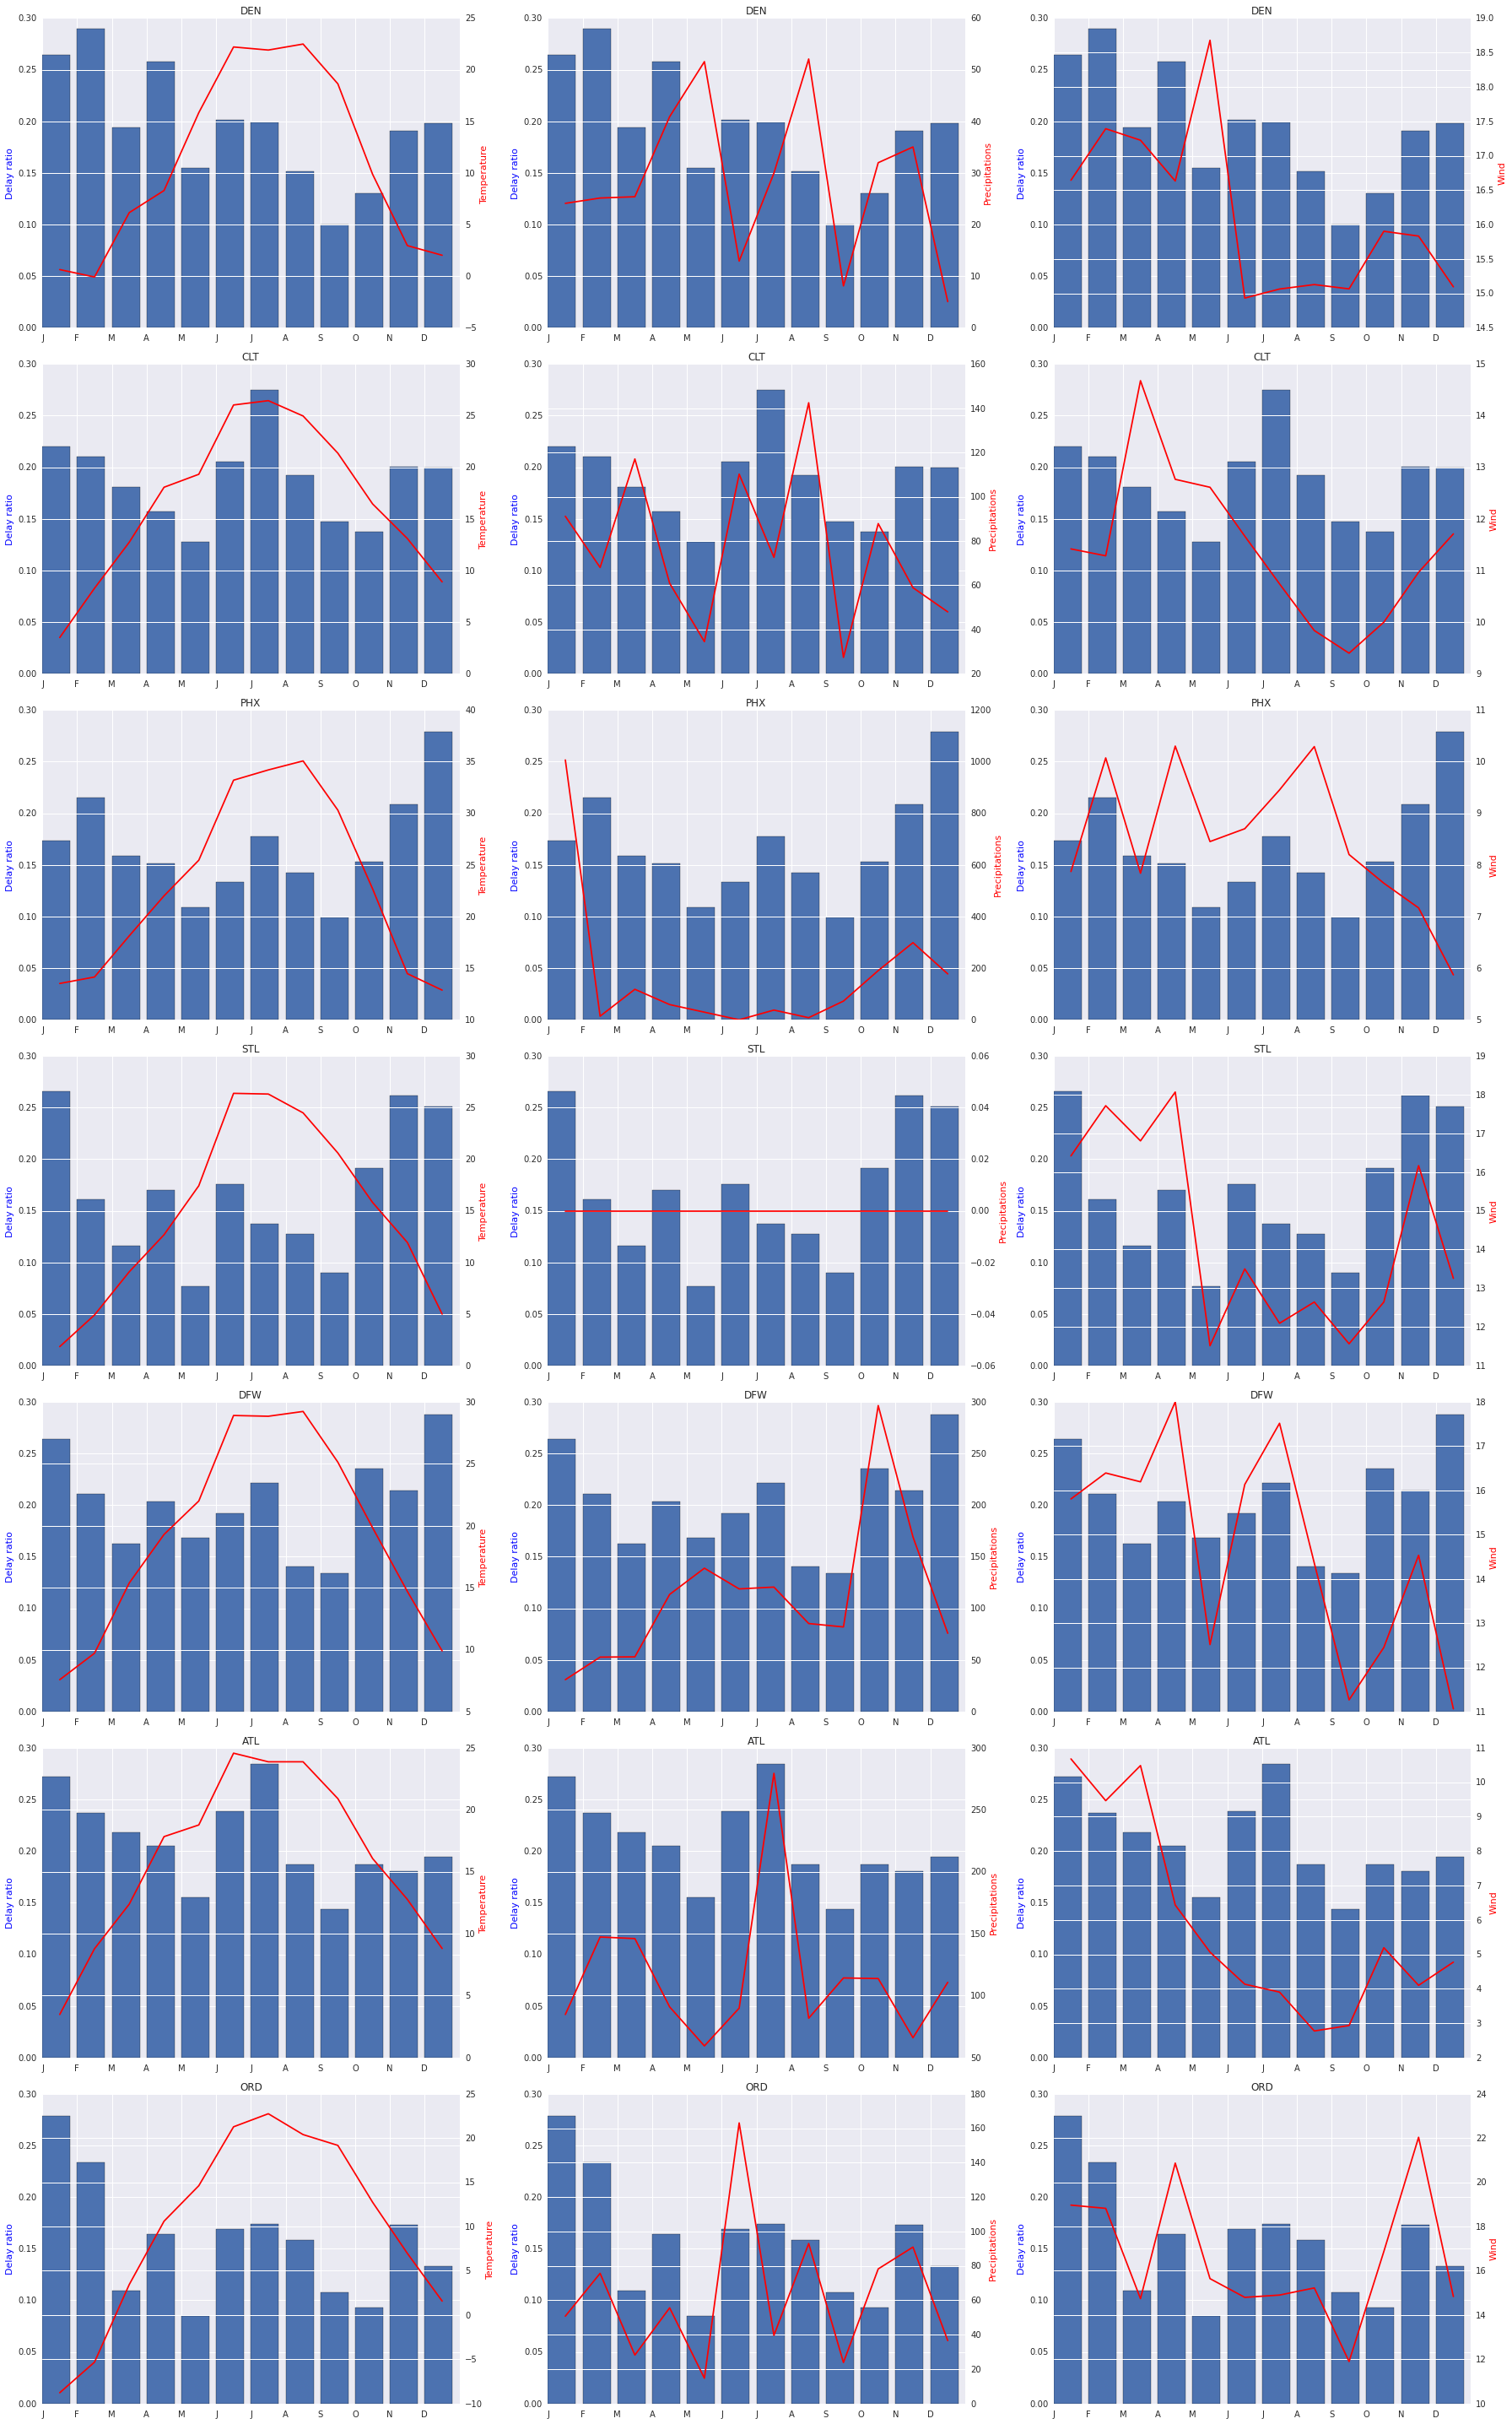

In [43]:
def condition_plot(ax, delays, conditions, y1label, y2label):
    ax.bar([x for x in range(len(delays))], [x[0] for x in delays])
    ax.set_ylabel(y1label, color='b')
    ax2 = ax.twinx()
    ax2.plot([x+0.5 for x in range(len(conditions))], [x[0] for x in conditions], color='r')
    ax2.set_ylabel(y2label, color='r')


airports = df_with_weather.select('airport').distinct().collect()
airport_found = len(airports)

# PLOT
# one plot for each airport and weather condition. so 3 plots (columns) avg(meantempm) avg(precipm) avg(meanwindspdm) and airport_found rows
nr = airport_found
nc = 3
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(25, 40))
plot_counter = 1
for airport in airports:
    df_curr_airport = df_with_weather[df_with_weather.airport == airport[0]]
    delays = df_curr_airport.select('delay_ratio').collect()
    mean_temp = df_curr_airport.select('mean_temp').collect()
    mean_precip = df_curr_airport.select('mean_precip').collect()
    mean_wind = df_curr_airport.select('mean_wind').collect()
    
    ax = plt.subplot(nr, nc, plot_counter)
    condition_plot(ax, delays, mean_temp, 'Delay ratio', 'Temperature')
    plt.title(airport[0])
    plt.xticks([x for x in range(len(months))], [x[0] for x in months], rotation='vertical')
    plot_counter += 1
    
    ax = plt.subplot(nr, nc, plot_counter)
    condition_plot(ax, delays, mean_precip, 'Delay ratio', 'Precipitations')
    plt.title(airport[0])
    plt.xticks([x for x in range(len(months))], [x[0] for x in months], rotation='vertical')
    plot_counter += 1
    
    ax = plt.subplot(nr, nc, plot_counter)
    condition_plot(ax, delays, mean_wind, 'Delay ratio', 'Wind')
    plt.title(airport[0])
    plt.xticks([x for x in range(len(months))], [x[0] for x in months], rotation='vertical')
    plot_counter += 1

plt.tight_layout()
plt.show()

Here it's possible to see 7 rows, one for each of the cities reported above, with 3 column each for representing the variation of temperature, precipitations and wind speed in relation to the delay ratio of each city. The blue bars represents the delay ratio (left y axis), the red line instead represents the particular weather condition information (right y axis).<br>
NB: the temperature information is reported only as an informative data: since we are considering the airports of US cities, there are not really extreme temperature conditions, so the delay should not be related with that.<br>
<br>
The principal problem with this type of analysis is that we are considering the precipitation sum and the wind speed average among all the days over each month, so it's not easy to see an evident correlation in all the cases; this because it may happen that there are intense precipitations (or high wind speed) only in some days of the month (with related delay correlation) while during the other days the weather conditions are good and from the final average it's not possible to evidence the correlation.<br>
Despite that, it's still possible to see that in some cases there is a correlation, or at least it could be.<br>
PRECIPITATIONS:<br>
Looking at the precipitations, we can see for example that in the month of **October**, in the case of **DFW**, there is an evident increment in the total amount of precipitations (it's important to consider that in this case we have an amount of precipitations equal to 300mm, which is relevant) with respect to the others month of the year, and at that corresponds also an increment in the delay ratio.<br>
The same thing can be said for **PHX** in the month of **November** (\*) or **ATL** in **July**.<br>
WIND SPEED:<br>
About the wind, it's difficult to identify it as the only (or the main) source of delay for a flight, unless its speed is really high. However, an high wind condition can be said for wind-speed > 50 km/h, and in this case we do not register months with a really high average speed. The airport which registers the highest average is **ORD**, and the highest pic is in the month of **November** (the second is **April**); since the delay ratio also increases in that month it could be that there have been windy days which could have caused delays.
<br>
The following analysis are made to confirm the possible relations.
<br>
(\*): there are also cases of wrong/missing data for the weather data:
- in the case of the precipitations over 'PHX' we can see a really evident increment during the first month, with a total of more than 1000 mm of precipitations. Analyzing deeply the situation we have find out that in January 28th, there are 777 mm of precipitations, which is impossible for a single day. So this is probably a wrong data in the dataset.
- the weather dataset does not contain any information about precipitations in 'STL' over the entire year

So first of all, in order to confirm what we have seen before, we print out the top 10 rows for precipitations and for wind speed. However, in this case, we do not consider the monthly average, because we are interested in finding, respectively, the days with more precipitations and with the highest speeds, in order to compare them with the other days in the same month.

In [12]:
print('Highest precipitations')
weather_df.orderBy('precipm', ascending=0).show(10)
print('Highest wind')
weather_df.orderBy('meanwindspdm', ascending=0).show(10)

Highest precipitations
+-------+---------+-------+------------+---+-----+----+
|airport|meantempm|precipm|meanwindspdm|day|month|year|
+-------+---------+-------+------------+---+-----+----+
|    PHX|       10| 777.24|           8| 28|    1|1994|
|    DFW|       20|  68.58|          18| 18|   10|1994|
|    DFW|       22|   63.5|          21|  7|   10|1994|
|    ORD|       20|   57.4|          16| 23|    6|1994|
|    ORD|        8|   56.9|          21| 31|   10|1994|
|    DFW|       21|  55.88|          13| 21|   10|1994|
|    PHX|       18|  55.12|           6| 11|   11|1994|
|    PHX|       16|  53.85|          11|  3|   11|1994|
|    PHX|       28|  47.24|          11|  3|   10|1994|
|    CLT|       23|  46.99|          11| 16|    8|1994|
+-------+---------+-------+------------+---+-----+----+
only showing top 10 rows

Highest wind
+-------+---------+-------+------------+---+-----+----+
|airport|meantempm|precipm|meanwindspdm|day|month|year|
+-------+---------+-------+------------+--

In [30]:
# function used to plot the bar chart (delay_ratio) and line chart (weather condition) on the same graph
def plot_bar_line(bar_data, line_data, ylabel):
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(111)
    ax.bar([x for x in range(len(bar_data))], bar_data)
    ax.set_ylabel('Delay ratio', color='b')
    ax2 = ax.twinx()
    ax2.plot([x+0.5 for x in range(len(line_data))], line_data, color='r')
    ax2.set_ylabel(ylabel, color='r')

    plt.title('Percentage of delayed flights and %s over days of the month' % ylabel)
    plt.xticks([x+0.5 for x in range(len(line_data))], [x+1 for x in range(len(line_data))])
    plt.xlim(0-0.5, len(line_data)+0.5)

    plt.show()

In [31]:
# function used to query the dataset extracting the delay ratio and the weather condition of a certain airport in a certain month
def weather_analysis(airport, month, condition):
    # QUERY
    # first we calculate per-day delay ratio
    #df_airport = df.withColumn('airport', df.Origin).union(df.withColumn('airport', df.Dest))
    df_filtered = df_airport.filter(df_airport.airport == airport).filter(df_airport.Month == month).withColumn('is_delay', func.when((df_airport.ArrDelay >= 15), 1).otherwise(0))
    df_filtered = df_filtered.groupBy(df_filtered.airport, df_filtered.DayofMonth).agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))
    # join (with respect to the airport and the day) with the weather database to obtain the dataframe with also the weather informations
    # and filter again respect to the month
    df_with_weather = df_filtered.withColumnRenamed('DayofMonth', 'day').join(weather_df, ['airport', 'day']).filter(weather_df.month == month)

    # PRINT & COLLECT
    df_with_weather.orderBy(condition, ascending=0).show()
    # here we also order by day and select to prepare the data for plotting
    data = df_with_weather.orderBy(df_with_weather.day).select('delay_ratio', condition).collect()

    # PLOT
    plot_bar_line([x[0] for x in data], [x[1] for x in data], condition)

**Precipitations: DFW October 1994**

+-------+---+-------------------+---------+-------+------------+-----+----+
|airport|day|        delay_ratio|meantempm|precipm|meanwindspdm|month|year|
+-------+---+-------------------+---------+-------+------------+-----+----+
|    DFW| 18| 0.7166551485832757|       20|  68.58|          18|   10|1994|
|    DFW|  7| 0.5207060420909708|       22|   63.5|          21|   10|1994|
|    DFW| 21| 0.7875084860828242|       21|  55.88|          13|   10|1994|
|    DFW| 16|  0.700486448922863|       21|   25.4|          21|   10|1994|
|    DFW| 20| 0.7331518039482642|       21|  17.78|          10|   10|1994|
|    DFW| 25|0.24587912087912087|       13|  15.24|          13|   10|1994|
|    DFW| 24| 0.6297814207650273|       21|  15.24|          13|   10|1994|
|    DFW| 26|0.11788896504455106|       11|  11.94|           3|   10|1994|
|    DFW| 19|0.11483253588516747|       23|   9.91|          10|   10|1994|
|    DFW| 17| 0.2272416153319644|       23|   5.08|          21|   10|1994|
|    DFW| 22

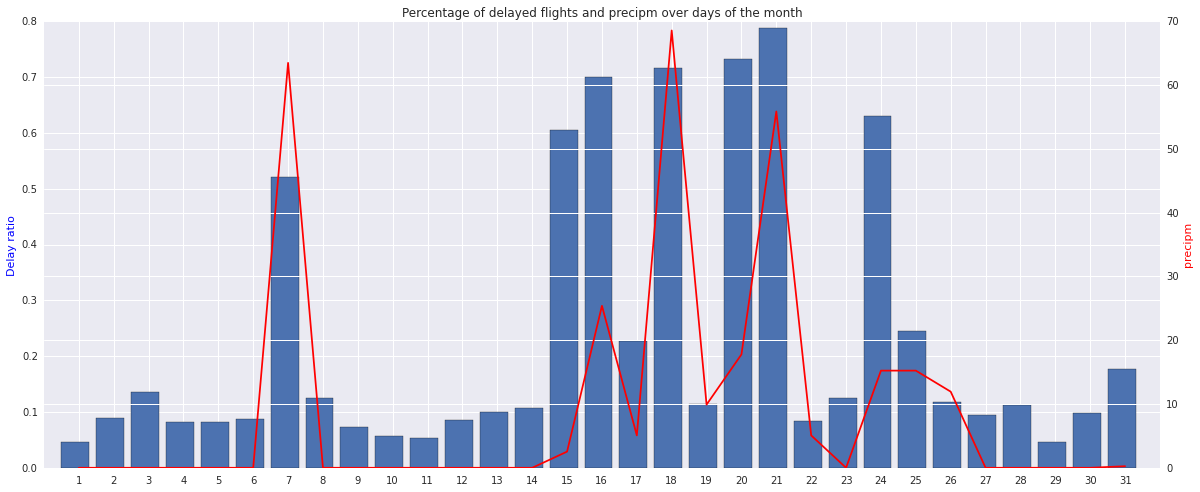

In [33]:
weather_analysis('DFW', 10, 'precipm')

**Wind speed: ORD October 1994**

+-------+---+--------------------+---------+-------+------------+-----+----+
|airport|day|         delay_ratio|meantempm|precipm|meanwindspdm|month|year|
+-------+---+--------------------+---------+-------+------------+-----+----+
|    ORD| 28| 0.34525357607282187|        2|    0.0|          45|   11|1994|
|    ORD| 18|  0.2025236593059937|        8|    0.0|          32|   11|1994|
|    ORD| 27|  0.6477039067854695|        9|  29.46|          32|   11|1994|
|    ORD| 21|  0.5562053281351527|        7|   1.02|          31|   11|1994|
|    ORD|  9| 0.20038046924540268|        9|   7.11|          29|   11|1994|
|    ORD|  1| 0.20102105934907466|        7|   2.03|          29|   11|1994|
|    ORD| 22| 0.11753614079195475|       -1|    0.0|          29|   11|1994|
|    ORD| 29|  0.1551614946168461|       -1|    0.0|          29|   11|1994|
|    ORD| 14| 0.07701941139636818|       11|   2.54|          26|   11|1994|
|    ORD| 13| 0.07065948855989233|       14|   4.06|          24|   11|1994|

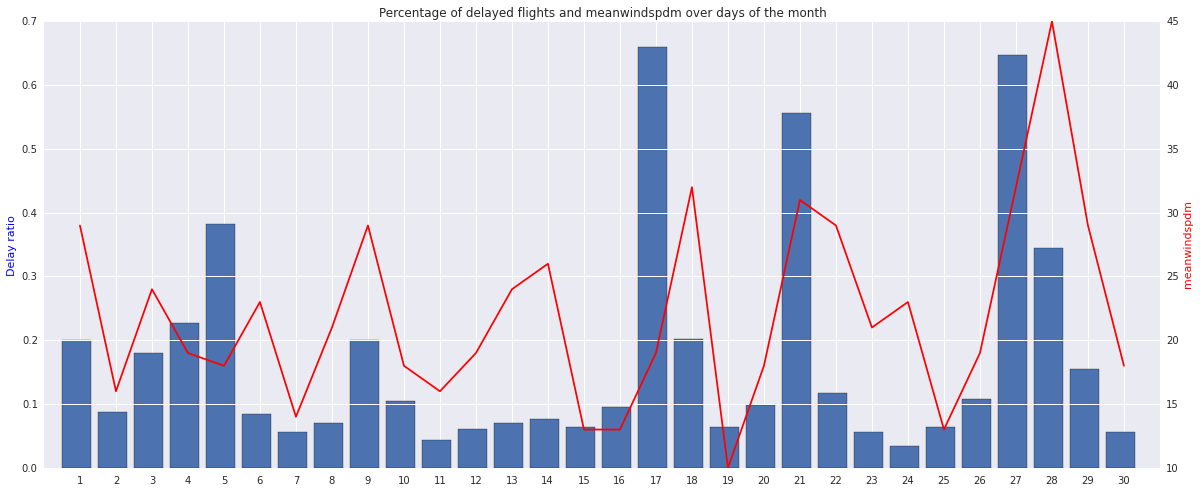

In [34]:
weather_analysis('ORD', 11, 'meanwindspdm')

**Precipitations: ORD June 1994**

+-------+---+--------------------+---------+-------+------------+-----+----+
|airport|day|         delay_ratio|meantempm|precipm|meanwindspdm|month|year|
+-------+---+--------------------+---------+-------+------------+-----+----+
|    ORD| 23|  0.4627450980392157|       20|   57.4|          16|    6|1994|
|    ORD| 24|  0.2885375494071146|       18|  33.27|          32|    6|1994|
|    ORD| 17|  0.1866840731070496|       28|   22.1|          10|    6|1994|
|    ORD| 20|  0.6513879922530665|       25|  18.03|          13|    6|1994|
|    ORD| 21|  0.1199238578680203|       24|  14.22|          13|    6|1994|
|    ORD| 14| 0.12640801001251564|       27|  10.67|          23|    6|1994|
|    ORD| 11| 0.16689466484268126|       19|   4.83|          10|    6|1994|
|    ORD| 13| 0.49841671944268523|       26|   2.29|          19|    6|1994|
|    ORD|  8| 0.06913890634820867|       13|   0.25|          26|    6|1994|
|    ORD|  2| 0.05109034267912772|       12|    0.0|          13|    6|1994|

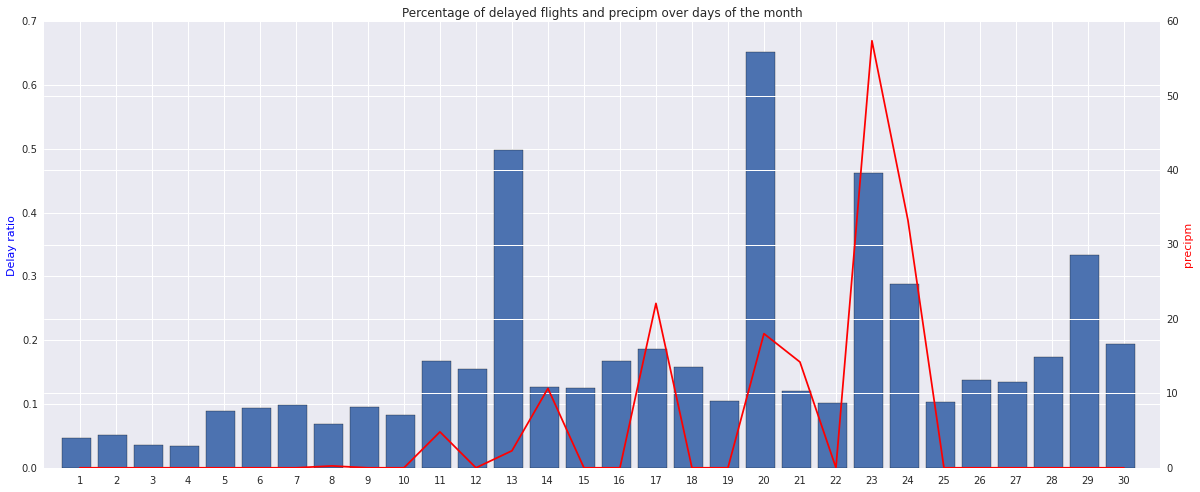

In [38]:
weather_analysis('ORD', 6, 'precipm')

**Precipitations: ORD October 1994**

+-------+---+--------------------+---------+-------+------------+-----+----+
|airport|day|         delay_ratio|meantempm|precipm|meanwindspdm|month|year|
+-------+---+--------------------+---------+-------+------------+-----+----+
|    ORD| 31|  0.5085173501577287|        8|   56.9|          21|   10|1994|
|    ORD|  8| 0.10296191819464035|       14|  16.51|          16|   10|1994|
|    ORD| 18| 0.13451776649746192|       18|   2.79|          21|   10|1994|
|    ORD|  7| 0.12198221092757307|       20|   1.02|          27|   10|1994|
|    ORD| 19|   0.064030131826742|       18|   1.02|          21|   10|1994|
|    ORD| 13|0.060983198506533914|       13|    0.0|           6|   10|1994|
|    ORD| 21|  0.1265743073047859|       13|    0.0|          10|   10|1994|
|    ORD|  6| 0.07440100882723834|       17|    0.0|          19|   10|1994|
|    ORD|  5|0.047080979284369114|       11|    0.0|          11|   10|1994|
|    ORD|  3|0.051964512040557666|       14|    0.0|          23|   10|1994|

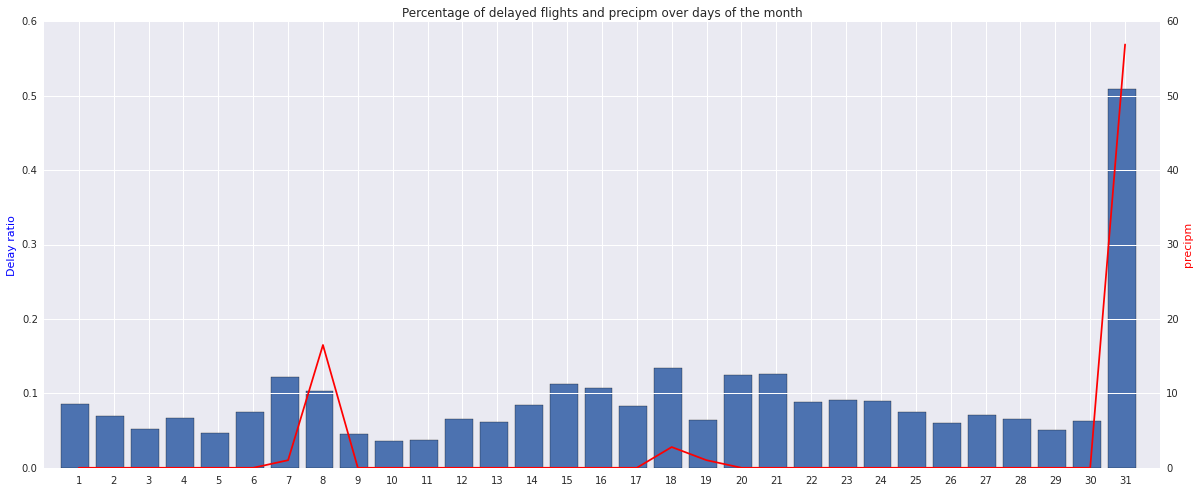

In [36]:
weather_analysis('ORD', 10, 'precipm')

**Precipitations: PHX November 1994**

+-------+---+-------------------+---------+-------+------------+-----+----+
|airport|day|        delay_ratio|meantempm|precipm|meanwindspdm|month|year|
+-------+---+-------------------+---------+-------+------------+-----+----+
|    PHX| 11|0.18631178707224336|       18|  55.12|           6|   11|1994|
|    PHX|  3|0.22348484848484848|       16|  53.85|          11|   11|1994|
|    PHX| 18|0.46266666666666667|       12|  34.04|          13|   11|1994|
|    PHX| 10|0.20100502512562815|       19|  20.83|          10|   11|1994|
|    PHX|  8|0.10256410256410256|       17|  19.05|           8|   11|1994|
|    PHX|  7|0.12287104622871046|       18|  19.05|           8|   11|1994|
|    PHX| 23| 0.2345679012345679|       18|  17.53|           5|   11|1994|
|    PHX| 12|0.11978465679676985|       14|  17.27|          10|   11|1994|
|    PHX| 19|0.18708827404479578|        8|  17.27|          14|   11|1994|
|    PHX| 26| 0.3574408901251738|       12|  16.76|          13|   11|1994|
|    PHX|  4

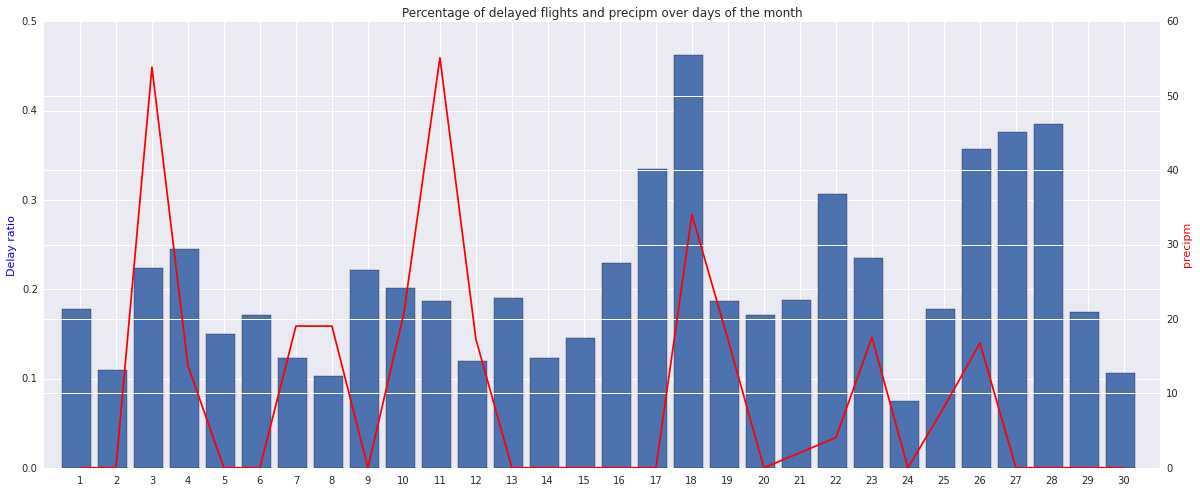

In [35]:
weather_analysis('PHX', 11, 'precipm')

**Precipitations: ATL July 1994**

+-------+---+-------------------+---------+-------+------------+-----+----+
|airport|day|        delay_ratio|meantempm|precipm|meanwindspdm|month|year|
+-------+---+-------------------+---------+-------+------------+-----+----+
|    ATL|  7|0.22639933166248954|       23|  42.67|           6|    7|1994|
|    ATL|  9| 0.3290378006872852|       25|  39.12|           2|    7|1994|
|    ATL|  5|0.36454849498327757|       22|  37.59|          14|    7|1994|
|    ATL| 31|0.28936170212765955|       23|  28.45|           3|    7|1994|
|    ATL| 10|0.34491525423728814|       24|  21.08|           3|    7|1994|
|    ATL| 24|0.20269133725820015|       26|  18.03|           3|    7|1994|
|    ATL| 19| 0.2602510460251046|       26|  13.97|           2|    7|1994|
|    ATL| 28| 0.2647058823529412|       23|  11.18|           2|    7|1994|
|    ATL| 16| 0.1591304347826087|       24|  10.92|           3|    7|1994|
|    ATL| 25|0.22883487007544007|       24|   9.65|           3|    7|1994|
|    ATL| 20

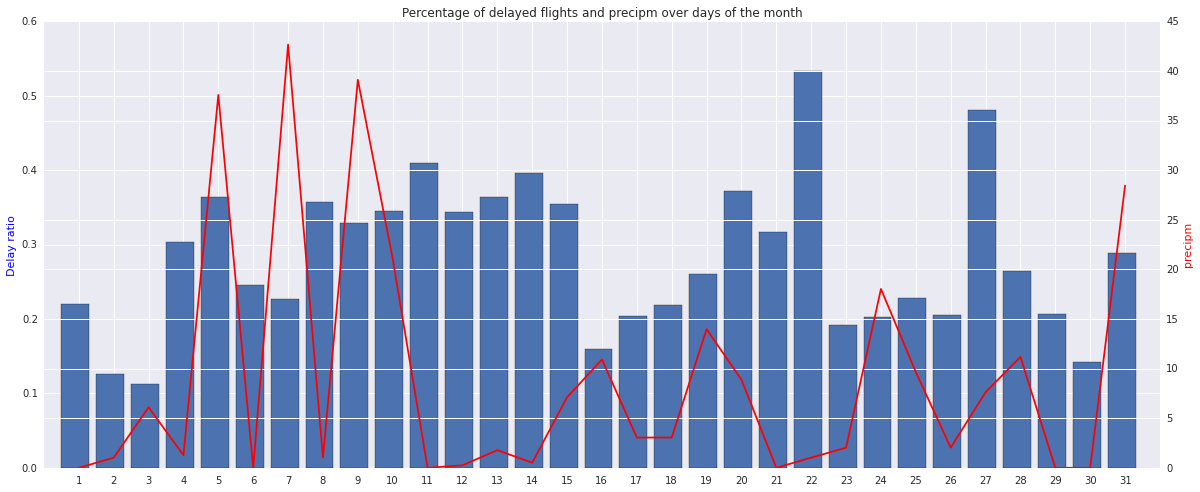

In [72]:
weather_analysis('ATL', 7, 'precipm')

From all those graphs we can absolutely confirm what it was assumed above: in some cases the weather condition may really influence the delay ratio of some airports. Obviously this has to be analyzed day by day (or better hour by hour) because the weather conditions may change in little time. Obviously there may be a lot of causes to the delay of a flight, but in some cases the correlation with the weather is really evident.<br>
Particularly interesting is the first produced plot: 'Precipitations: DFW October 1994'. In that case it's really clear that as the precipitations increase, it increases also the average delay of the day: days 7, 18 and 21 really evidence this! During those days the amount of precipitations reaches values over 50mm.<br>
The same thing can be said about 'Precipitations: ORD October 1994' and 'Precipitations: ORD June 1994': in the first case the only day with a lot of precipitations is October 31th, and it is also the only day which registers an evident delay! In the same way, also in June there are two days (23-24) which register a very high amount of precipitations, and the pic on the blue bar is certainly caused by the weather.<br>
About the wind speed, instead, we can not see a so well evident correlation; in the produced plot (Wind speed: ORD October 1994) the only day with an high wind speed (~45 km/h) is the 28th and the delay is a little above the average.